<a href="https://colab.research.google.com/github/XinzhiZ-safeBVM/QA-tool/blob/prolong-study/Prolong_QA_tool_demo_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QA Tool Backend (Run this when first connect)

## QA Automatic Tool

In [ ]:
import pandas as pd
import sys
from typing import Tuple

def ReadSensirionFile(filepath: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Reads a Sensirion file and returns three pandas DataFrames:
    header_PD, breath_table_PD, and real_data_PD.
    """
    with open(filepath, newline='', encoding="utf-8") as csvfile:
        # Read the entire file
        file_content = csvfile.readlines()

    # Initialize variables
    headers = []
    breath_table_start = None
    data_start = None

    # Find the start of breath table and data
    for i, line in enumerate(file_content):
        if line.startswith("Breath Count,Time (s)"):
            breath_table_start = i
        elif line.startswith("Time,Timestamp,Flow,Pressure"):
            data_start = i
            break
        if breath_table_start is None:
            headers.append(line.strip().split(','))

    # Create header_PD
    header_PD = pd.DataFrame(headers)

    # Create breath_table_PD
    if breath_table_start is not None and data_start is not None:
        breath_table_PD = pd.read_csv(filepath, skiprows=breath_table_start, nrows=data_start-breath_table_start-1)
    else:
        breath_table_PD = pd.DataFrame()

    # Create real_data_PD
    if data_start is not None:
        # Read column names and units
        column_names = file_content[data_start].strip().split(',')
        column_units = file_content[data_start + 1].strip().split(',')

        # Read the actual data
        real_data_PD = pd.read_csv(filepath, skiprows=data_start+2, names=column_names)

        # Add units as a new row at the top of the DataFrame
        real_data_PD.loc[-1] = column_units
        real_data_PD.index = real_data_PD.index + 1
        real_data_PD = real_data_PD.sort_index()

        # Convert columns to appropriate types
        for column in real_data_PD.columns:
            if column == "Note":
                real_data_PD.loc[1:, column] = real_data_PD.loc[1:, column].astype(str)
            elif column in ["start_flag", "stop_flag", "Breath Count"]:
                real_data_PD.loc[1:, column] = pd.to_numeric(real_data_PD.loc[1:, column], errors='coerce').astype('Int64')
            else:
                real_data_PD.loc[1:, column] = pd.to_numeric(real_data_PD.loc[1:, column], errors='coerce')
    else:
        real_data_PD = pd.DataFrame()

    # Check for TSI device
    if not header_PD.empty and "Device Name" in header_PD[0].values:
        device_name_row = header_PD[header_PD[0] == "Device Name"].iloc[0]
        if len(device_name_row) > 1 and "TSI" in device_name_row[1]:
            sys.stderr.write("File indicates TSI device. Please use the ReadTsiFile.\n")

    return header_PD, breath_table_PD, real_data_PD

import pandas as pd
import numpy as np
from typing import Tuple, List

def detect_breaths(df: pd.DataFrame,
                   time_col: str = "Time",
                   flow_col: str = "Flow",
                   pressure_col: str = "Pressure") -> Tuple[List[int], List[int]]:
    """
    Detect breath start and end points in respiratory data.

    This function analyzes flow and pressure data to identify the start and end points of breaths.
    It accounts for a specific DataFrame structure where the first row contains column names and
    the second row contains units. The function preserves the original DataFrame's index.

    Args:
        df (pd.DataFrame): The input DataFrame containing respiratory data.
        time_col (str): Name of the column containing time data. Default is "Time".
        flow_col (str): Name of the column containing flow data. Default is "Flow".
        pressure_col (str): Name of the column containing pressure data. Default is "Pressure".

    Returns:
        Tuple[List[int], List[int]]: Two lists containing the indices of breath start and end points,
                                     corresponding to the original DataFrame's index.

    Raises:
        ValueError: If required columns are missing or if data conversion fails.
    """
    # Define thresholds
    positive_flow_threshold = (1.0, 5.0)
    positive_pressure_threshold = 1.0
    negative_flow_threshold = (1.0, 2.0)
    negative_pressure_threshold = 0.1

    start_points = []
    end_points = []

    # Error handling: Check if required columns exist
    required_columns = [time_col, flow_col, pressure_col]
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"Missing one or more required columns: {required_columns}")

    try:
        # Extract data from the third row onwards, preserving the original index
        data_df = df.iloc[2:]

        # Convert columns to numeric, coercing errors to NaN
        flow_data = pd.to_numeric(data_df[flow_col], errors='coerce').values
        pressure_data = pd.to_numeric(data_df[pressure_col], errors='coerce').values
    except Exception as e:
        raise ValueError(f"Error in data conversion: {str(e)}")

    i = 0
    while i < len(data_df) - 50:  # Ensure we have enough data points ahead
        # Check for breath start
        if flow_data[i] > positive_flow_threshold[0]:
            peak_flow = np.nanmax(flow_data[i:i+10])
            peak_pressure = np.nanmax(pressure_data[i:i+10])

            if peak_flow > positive_flow_threshold[1] and peak_pressure > positive_pressure_threshold:
                start_points.append(data_df.index[i])

                # Look for breath end
                j = i + 40
                while j < len(data_df):
                    # Changed logic: Check if average of past 5 points is less than threshold
                    mean_flow = np.nanmean(flow_data[j-5:j])
                    peak_flow = np.nanmax(flow_data[j:j+10])
                    peak_pressure = np.nanmax(pressure_data[j-10:j])
                    if mean_flow < negative_flow_threshold[0] and peak_flow > negative_flow_threshold[1] and peak_pressure < negative_pressure_threshold:
                        if np.nanmean(flow_data[j:j+10]) < negative_flow_threshold[0]:
                            pass
                        else:
                            end_points.append(data_df.index[j])
                            i = j - 10  # Move main loop to end of this breath
                            break
                    j += 1

                if len(end_points) < len(start_points):
                    # If we didn't find an end point, remove the last start point
                    start_points.pop()

        i += 1

    return start_points, end_points

import pandas as pd
import numpy as np
from typing import List, Tuple, Optional

def detect_single_breath_phases(
    flow_data: pd.Series,
    breath_start: int,
    breath_end: int
) -> Tuple[Optional[int], Optional[int]]:
    """
    Detect inspiration end (insp_end) and expiration start (exp_start) for a single breath,
    then refine insp_end by finding the true start of the low-flow plateau if exp_start is distinct.
    Ensures insp_end <= exp_start.
    """

    # === Configurable thresholds and window sizes ===
    INSP_END_SKIP = 31              # samples to skip before searching for insp_end
    INSP_END_PLATEAU_LEN = 5        # look-ahead samples for plateau detection at insp_end
    INSP_END_FLOW_THRESH = 1.0      # SL/min: flow must be below this to mark plateau

    EXP_START_LEN = 5               # samples for exp_start detection window
    EXP_START_FLOW_THRESH = -4.0    # SL/min: negative flow threshold for exp_start

    PLATEAU_REFINE_THRESH = 0.5     # SL/min: flow must be below this for plateau start

    # Validate range
    if breath_start >= breath_end:
        raise ValueError(f"Invalid breath range: start {breath_start} is not before end {breath_end}")

    # 1) Isolate the breath segment by label
    breath_flow = flow_data.loc[breath_start:breath_end]
    idxs = breath_flow.index  # preserve labels

    # 2) Find inspiration end (insp_end)
    insp_end = None
    for i in range(INSP_END_SKIP, len(breath_flow) - INSP_END_PLATEAU_LEN):
        prev_flow = breath_flow.iloc[i - 1]
        curr_flow = breath_flow.iloc[i]
        next_plateau = breath_flow.iloc[i : i + INSP_END_PLATEAU_LEN]
        if (prev_flow > 0
            and curr_flow < INSP_END_FLOW_THRESH
            and all(next_plateau < INSP_END_FLOW_THRESH)):
            insp_end = idxs[i]
            break

    exp_start = None
    if insp_end is not None:
        insp_pos = idxs.get_loc(insp_end)

        # 3) Find expiration start (exp_start)
        for i in range(insp_pos, len(breath_flow) - EXP_START_LEN):
            curr_flow = breath_flow.iloc[i]
            next_flow = breath_flow.iloc[i + 1]
            next_window = breath_flow.iloc[i + 1 : i + 1 + EXP_START_LEN]
            if (curr_flow > EXP_START_FLOW_THRESH
                and next_flow < EXP_START_FLOW_THRESH
                and all(next_window < EXP_START_FLOW_THRESH)):
                exp_start = idxs[i]
                break

        # fallback if no exp_start found
        if exp_start is None:
            exp_start = insp_end

        # 4) Plateau refinement: if exp_start is distinct, adjust insp_end
        if exp_start != insp_end:
            exp_pos = idxs.get_loc(exp_start)
            p = exp_pos
            # move backward until flow exits the low-flow plateau
            while p >= insp_pos and breath_flow.iloc[p] < PLATEAU_REFINE_THRESH:
                p -= 1
            plateau_pos = p + 1
            # ensure plateau_pos does not exceed exp_pos
            if plateau_pos > exp_pos:
                plateau_pos = exp_pos
            plateau_start = idxs[plateau_pos]
            insp_end = plateau_start

    # final safety: ensure insp_end <= exp_start
    if insp_end is not None and exp_start is not None:
        insp_pos_final = idxs.get_loc(insp_end)
        exp_pos_final = idxs.get_loc(exp_start)
        if insp_pos_final > exp_pos_final:
            insp_end = exp_start

    return insp_end, exp_start

def detect_breath_phases(df: pd.DataFrame,
                             breath_starts: List[int],
                             breath_ends: List[int],
                             flow_col: str = "Flow") -> Tuple[List[int], List[int]]:
    """
    Detect inspiration end (insp_end) and expiration start (exp_start) points for all breaths.

    Args:
        df (pd.DataFrame): The input DataFrame containing respiratory data.
        flow_col (str): Name of the column containing flow data.
        breath_starts (List[int]): List of breath start indices.
        breath_ends (List[int]): List of breath end indices.

    Returns:
        Tuple[List[int], List[int]]: Two lists containing the indices of insp_end and exp_start points.

    Raises:
        ValueError: If the flow column is missing, if data conversion fails, or if no insp_end is found for any breath.
    """
    if flow_col not in df.columns:
        raise ValueError(f"Missing flow column: {flow_col}")

    try:
        flow_data = pd.to_numeric(df[flow_col], errors='coerce')
    except Exception as e:
        raise ValueError(f"Error in flow data conversion: {str(e)}")

    insp_end_points = []
    exp_start_points = []

    for start, end in zip(breath_starts, breath_ends):
        insp_end, exp_start = detect_single_breath_phases(flow_data, start, end)

        if insp_end is None:
            print(f"\033[93mWARNING: No inspiration end point found for breath starting at index {start}\033[0m")
            insp_end = start + 1
            exp_start = start + 1

        insp_end_points.append(insp_end)
        exp_start_points.append(exp_start)

    return insp_end_points, exp_start_points

import pandas as pd
import numpy as np
from typing import Tuple

def xyz_sotair_single(
    time_data: pd.Series,
    flow_data: pd.Series,
    breath_start: int,
    insp_end: int,
    exp_start: int,
    breath_end: int
) -> Tuple[float, float, bool]:
    """
    Analyze characteristics of a single breath and determine SOTAIR flag.

    Args:
        time_data (pd.Series): Series containing time data.
        flow_data (pd.Series): Series containing flow data.
        breath_start (int): Index of breath start.
        insp_end (int): Index of inspiration end.
        exp_start (int): Index of expiration start.
        breath_end (int): Index of breath end.

    Returns:
        Tuple[float, float, bool]: A tuple containing:
            1. Flow gradient at insp_end point.
            2. Time gap between insp_end and exp_start.
            3. SOTAIR flag (True if conditions are met, False otherwise).

    Raises:
        ValueError: If there's an issue with the input data or indices.
    """
    # Define thresholds as constants within the function
    GRADIENT_THRESHOLD = -1000
    TIME_GAP_THRESHOLD = 0.25

    # Validate indices
    if not (breath_start <= insp_end <= exp_start <= breath_end):
        raise ValueError(f"Invalid breath indices: start={breath_start}, insp_end={insp_end}, exp_start={exp_start}, end={breath_end}")

    # Calculate minimum flow gradient near insp_end
    if insp_end > breath_start + 3:  # Ensure we have at least 4 points to work with
        gradients = []

        # Calculate gradients for three consecutive pairs
        for i in range(3):
            end_idx = insp_end - i
            start_idx = insp_end - (i + 1)

            time_diff = time_data.iloc[end_idx] - time_data.iloc[start_idx]
            flow_diff = flow_data.iloc[end_idx] - flow_data.iloc[start_idx]

            gradient = flow_diff / time_diff if time_diff != 0 else np.nan
            gradients.append(gradient)

        # Get the minimum gradient, ignoring NaN values
        gradient = np.nanmin(gradients) if gradients else np.nan
    else:
        gradient = np.nan

    # Calculate time gap between insp_end and exp_start
    time_gap = time_data.iloc[exp_start] - time_data.iloc[insp_end]

    # Determine SOTAIR flag
    sotair_flag = gradient < GRADIENT_THRESHOLD and time_gap > TIME_GAP_THRESHOLD

    return gradient, time_gap, sotair_flag

def find_max_in_slice(data: pd.Series, start_index: int, end_index: int) -> float:
    """
    Find the maximum value in a slice of data between start and end indices.

    Args:
        data (pd.Series): Series containing the data.
        start_index (int): Start index for the slice.
        end_index (int): End index for the slice.

    Returns:
        float: Maximum value in the specified slice.

    Raises:
        ValueError: If indices are invalid or if the slice is empty.
    """
    if start_index >= end_index:
        raise ValueError("Start index must be less than end index.")

    if start_index < data.index.min() or end_index > data.index.max():
        raise ValueError("Start or end index out of bounds.")

    # Select data within the specified range
    selected_data = data.loc[start_index:end_index]

    if selected_data.empty:
        raise ValueError("No data points in the specified range.")

    # Find the maximum value
    max_value = selected_data.max()

    return float(max_value)


def calculate_volume(time_data: pd.Series,
                     flow_data: pd.Series,
                     start_index: int,
                     end_index: int) -> float:
    """
    Calculate the volume by integrating flow data between start and end indices.

    Args:
        time_data (pd.Series): Series containing time data.
        flow_data (pd.Series): Series containing flow data.
        start_index (int): Start index for integration.
        end_index (int): End index for integration.

    Returns:
        float: Calculated volume.

    Raises:
        ValueError: If the data series are not aligned or if indices are invalid.
    """
    if len(time_data) != len(flow_data):
        raise ValueError("Time and flow data series must have the same length.")

    if start_index >= end_index:
        raise ValueError("Start index must be less than end index.")

    if start_index < 0 or end_index >= len(time_data):
        raise ValueError("Start or end index out of bounds.")

    # Select data within the specified range
    selected_time = time_data.iloc[start_index:end_index+1]
    selected_flow = flow_data.iloc[start_index:end_index+1]

    if len(selected_time) < 2:
        raise ValueError("Not enough data points between start and end for integration.")

    # Perform integration using trapezoidal rule
    volume = np.trapz(y=selected_flow, x=selected_time)

    # Convert the volume unit to ml
    volume = volume / 60 * 1000

    return volume



In [ ]:
import pandas as pd
import numpy as np
from typing import List, Tuple

def detect_breath_refine(
    df: pd.DataFrame,
    breath_starts: List[int],
    breath_ends: List[int],
    flow_col: str = 'Flow'
) -> Tuple[List[int], List[int]]:
    """
    Refine breath detection by snapping to a small-threshold crossing near zero.
    """

    # === Configurable thresholds and window sizes ===
    ZERO_TOL = 0.5            # SL/min: tolerance around nominal zero
    BACK_WIN_START = 40       # samples to look backward from coarse start
    FWD_WIN_END = 20          # samples to look forward  from coarse end

    # Remove first breath if it starts too early
    if breath_starts and breath_starts[0] < 10:
        breath_starts.pop(0)
        breath_ends.pop(0)

    refined_starts = []
    refined_ends = []

    flow = pd.to_numeric(df[flow_col], errors='coerce').values
    N = len(flow)

    for start, end in zip(breath_starts, breath_ends):
        # --- Refine breath-start by thresholded zero crossing --------------
        lo = max(0, start - BACK_WIN_START)
        for i in range(start - 1, lo - 1, -1):
            f_i  = flow[i]
            f_ip = flow[i + 1] if i + 1 < N else None
            # crossing upward past +ZERO_TOL
            if f_ip is not None and f_i <= ZERO_TOL and f_ip >= ZERO_TOL:
                # choose the sample closer to true zero
                refined_starts.append(i if abs(f_i) < abs(f_ip) else i + 1)
                break
        else:
            refined_starts.append(start)

        # --- Refine breath-end by thresholded zero crossing ---------------
        hi = min(N - 1, end + FWD_WIN_END)
        for i in range(end, hi):
            f_i  = flow[i]
            f_ip = flow[i + 1] if i + 1 < N else None
            # crossing downward past ZERO_TOL
            if f_ip is not None and f_i >= ZERO_TOL and f_ip <= ZERO_TOL:
                refined_ends.append(i if abs(f_i) < abs(f_ip) else i + 1)
                break
        else:
            refined_ends.append(end)

    return refined_starts, refined_ends

def check_QA_table(qa_breath_table: pd.DataFrame) -> pd.DataFrame:
    """
    Check and clean the QA breath table by applying various validation criteria.
    Currently checks:
    - Removes rows with positive expiratory volume
    - Reassigns breath numbers sequentially

    Args:
        qa_breath_table (pd.DataFrame): The QA breath table generated by generate_qa_breath_table()

    Returns:
        pd.DataFrame: A cleaned DataFrame with invalid rows removed and breath numbers reassigned

    Raises:
        ValueError: If 'expiratory_volume' column is missing from the input DataFrame
    """
    # Check if required column exists
    if 'expiratory_volume' not in qa_breath_table.columns:
        raise ValueError("Input DataFrame is missing 'expiratory_volume' column")

    try:
        # Create a copy to avoid modifying the original DataFrame
        cleaned_table = qa_breath_table.copy()

        # Remove rows where expiratory_volume > 0
        cleaned_table = cleaned_table[cleaned_table['expiratory_volume'] <= 0]

        # Reset the index and reassign breath numbers from 1
        cleaned_table = cleaned_table.reset_index(drop=True)
        cleaned_table['breath_number'] = range(1, len(cleaned_table) + 1)

        return cleaned_table

    except Exception as e:
        raise RuntimeError(f"An error occurred while cleaning the QA breath table: {str(e)}")

In [ ]:
import pandas as pd
import numpy as np
from typing import List, Tuple

def generate_qa_breath_table(real_data_PD: pd.DataFrame) -> pd.DataFrame:
    """
    Generate a QA breath table from the original respiratory data.

    This function processes respiratory data to create a table summarizing key metrics
    for each detected breath. It calculates various parameters such as breath phases,
    volumes, and timings.

    Args:
        real_data_PD (pd.DataFrame): The original DataFrame containing respiratory data.
                                     Expected columns: 'Time', 'Flow', 'Pressure'

    Returns:
        pd.DataFrame: A new DataFrame (QA_breath_table_PD) with each row representing
                      a single breath and columns for various breath metrics.

    Raises:
        ValueError: If required columns are missing from the input DataFrame.
        RuntimeError: If no breaths are detected in the data.
    """
    # Check if required columns exist in the input DataFrame
    required_columns = ['Time', 'Flow', 'Pressure']
    if not all(col in real_data_PD.columns for col in required_columns):
        raise ValueError(f"Input DataFrame is missing one or more required columns: {required_columns}")

    try:
        # Detect breaths and phases
        start_points, end_points = detect_breaths(real_data_PD)
        start_points, end_points = detect_breath_refine(real_data_PD, start_points, end_points)
        insp_end_points, exp_start_points = detect_breath_phases(real_data_PD, start_points, end_points)

        if len(start_points) == 0:
            raise RuntimeError("No breaths detected in the data.")

        # Initialize lists to store data for each column
        breath_data = []

        # Iterate through each breath
        for i, (start, end, insp_end, exp_start) in enumerate(zip(start_points, end_points, insp_end_points, exp_start_points), 1):
            try:
                # Calculate required values
                max_pressure = find_max_in_slice(real_data_PD['Pressure'], start, end)
                max_flow = find_max_in_slice(real_data_PD['Flow'], start, end)
                inspiratory_volume = calculate_volume(real_data_PD['Time'], real_data_PD['Flow'], start, exp_start)
                expiratory_volume = calculate_volume(real_data_PD['Time'], real_data_PD['Flow'], exp_start, end)
                inspiratory_time = real_data_PD['Time'].loc[exp_start] - real_data_PD['Time'].loc[start]
                inspiratory_flow_time = real_data_PD['Time'].loc[insp_end] - real_data_PD['Time'].loc[start]
                _, _, sotair_flag = xyz_sotair_single(real_data_PD['Time'], real_data_PD['Flow'], start, insp_end, exp_start, end)

                # Append data for this breath
                breath_data.append({
                    'breath_number': i,
                    'breath_start_idx': start,
                    'insp_stop_idx': insp_end,
                    'exp_start_idx': exp_start,
                    'breath_end_idx': end,
                    'breath_start_time': real_data_PD['Time'].loc[start],
                    'insp_stop_time': real_data_PD['Time'].loc[insp_end],
                    'exp_start_time': real_data_PD['Time'].loc[exp_start],
                    'breath_end_time': real_data_PD['Time'].loc[end],
                    'peak_pressure': max_pressure,
                    'peak_flow': max_flow,
                    'inspiratory_volume': inspiratory_volume,
                    'expiratory_volume': expiratory_volume,
                    'inspiratory_time': inspiratory_time,
                    'inspiratory_flow_time': inspiratory_flow_time,
                    'noise': pd.NA,  # Using pd.NA for boolean NA values
                    'sotair': sotair_flag  # Using pd.NA for boolean NA values
                })
            except Exception as e:
                print(f"Error processing breath {i}: {str(e)}")
                continue

        # Create DataFrame from the collected data
        QA_breath_table_PD = pd.DataFrame(breath_data)

        # Set the data types for 'noise' and 'sotair' columns
        QA_breath_table_PD['noise'] = QA_breath_table_PD['noise'].astype('boolean')
        QA_breath_table_PD['sotair'] = QA_breath_table_PD['sotair'].astype('boolean')

        return QA_breath_table_PD

    except Exception as e:
        raise RuntimeError(f"An error occurred while generating the QA breath table: {str(e)}")


In [ ]:
import pandas as pd
import numpy as np
from typing import List, Tuple

def refine_qa_breath_table(real_data_PD: pd.DataFrame, user_breath_table_PD: pd.DataFrame) -> pd.DataFrame:
    """
    Refine a user-provided QA breath table by recalculating breath metrics using original respiratory data.
    Index 0 is reserved for units and will be preserved as-is.

    This function takes an existing breath table containing breath indices and updates the calculated
    metrics using the original respiratory data.

    Args:
        real_data_PD (pd.DataFrame): The original DataFrame containing respiratory data.
                                    Expected columns: 'Time', 'Flow', 'Pressure'
        user_breath_table_PD (pd.DataFrame): Existing breath table with breath indices.
                                           Expected columns: 'breath_number', 'breath_start_idx',
                                           'insp_stop_idx', 'exp_start_idx', 'breath_end_idx'
                                           Index 0 contains units.

    Returns:
        pd.DataFrame: Updated breath table with recalculated metrics, preserving units in index 0

    Raises:
        ValueError: If required columns are missing from either DataFrame
    """
    # Check if required columns exist in the input DataFrames
    real_data_required_columns = ['Time', 'Flow', 'Pressure']
    breath_table_required_columns = [
        'breath_number', 'breath_start_idx', 'insp_stop_idx',
        'exp_start_idx', 'breath_end_idx'
    ]

    if not all(col in real_data_PD.columns for col in real_data_required_columns):
        raise ValueError(f"real_data_PD is missing one or more required columns: {real_data_required_columns}")

    if not all(col in user_breath_table_PD.columns for col in breath_table_required_columns):
        raise ValueError(f"user_breath_table_PD is missing one or more required columns: {breath_table_required_columns}")

    try:
        # Create a copy of the user breath table to avoid modifying the original
        refined_breath_table = user_breath_table_PD.copy()

        # Iterate through each breath in the table, starting from index 1 (skip units row)
        for idx in refined_breath_table.index[1:]:
            try:
                # Extract indices for this breath
                start = refined_breath_table.loc[idx, 'breath_start_idx']
                end = refined_breath_table.loc[idx, 'breath_end_idx']
                insp_end = refined_breath_table.loc[idx, 'insp_stop_idx']
                exp_start = refined_breath_table.loc[idx, 'exp_start_idx']

                # Calculate required values
                max_pressure = find_max_in_slice(real_data_PD['Pressure'], start, end)
                max_flow = find_max_in_slice(real_data_PD['Flow'], start, end)
                inspiratory_volume = calculate_volume(real_data_PD['Time'], real_data_PD['Flow'], start, exp_start)
                expiratory_volume = calculate_volume(real_data_PD['Time'], real_data_PD['Flow'], exp_start, end)
                inspiratory_time = real_data_PD['Time'].iloc[exp_start] - real_data_PD['Time'].iloc[start]
                inspiratory_flow_time = real_data_PD['Time'].iloc[insp_end] - real_data_PD['Time'].iloc[start]

                # Update the refined breath table with new calculations
                refined_breath_table.loc[idx, 'peak_pressure'] = max_pressure
                refined_breath_table.loc[idx, 'peak_flow'] = max_flow
                refined_breath_table.loc[idx, 'inspiratory_volume'] = inspiratory_volume
                refined_breath_table.loc[idx, 'expiratory_volume'] = expiratory_volume
                refined_breath_table.loc[idx, 'inspiratory_time'] = inspiratory_time
                refined_breath_table.loc[idx, 'inspiratory_flow_time'] = inspiratory_flow_time

            except Exception as e:
                print(f"Error processing breath at index {idx}: {str(e)}")
                # Set values to NaN for this breath if calculation fails
                error_columns = [
                    'peak_pressure', 'peak_flow', 'inspiratory_volume',
                    'expiratory_volume', 'inspiratory_time', 'inspiratory_flow_time'
                ]
                refined_breath_table.loc[idx, error_columns] = np.nan
                continue

        return refined_breath_table

    except Exception as e:
        raise RuntimeError(f"An error occurred while refining the QA breath table: {str(e)}")

## QA Breath Review

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_data(df, x_col="Time", y1_col="Flow", y2_col="Pressure", start_row=1, end_row=None, **kwargs):
    """
    Plot two data series from a pandas DataFrame against a common x-axis using label-based indexing.
    Index 0 contains units and is used for axis labels.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data to be plotted.
    x_col (str): The name of the column to be used for the x-axis. Default is "Time".
    y1_col (str): The name of the column for the first y-axis. Default is "Flow".
    y2_col (str): The name of the column for the second y-axis. Default is "Pressure".
    start_row: The starting row number for the data slice. Default is 1 (first data row).
    end_row: The ending row number for the data slice. Default is None (uses last row).
    **kwargs: Additional keyword arguments.
        time_flag (tuple): Optional. If provided, draws vertical lines at specified row numbers.
        background_flag (bool): Optional. If True, adds light yellow background.
        breath_number (int): Optional. If provided, adds breath number to title.
        title (str): Optional. Custom title for the plot.
        background_text (dict): Optional. Dictionary containing text settings:
            - 'text': str, the text to display
            - 'color': str, color of the text (default: 'red')
            - 'alpha': float, transparency (default: 0.2)
            - 'rotation': float, rotation angle in degrees (default: 45)
            - 'size': float, font size (default: 100)
    """
    try:
        # Validate columns
        for col in [x_col, y1_col, y2_col]:
            if col not in df.columns:
                raise ValueError(f"Column '{col}' not found in the DataFrame.")

        # Get units from index 0
        units = {
            x_col: str(df.loc[0, x_col]),
            y1_col: str(df.loc[0, y1_col]),
            y2_col: str(df.loc[0, y2_col])
        }

        # Handle end_row
        if end_row is None:
            end_row = df.index[-1]

        # Validate row numbers
        if start_row not in df.index or end_row not in df.index:
            raise ValueError("start_row or end_row not found in DataFrame index.")
        if start_row <= 0:
            raise ValueError("start_row must be greater than 0 to skip units row.")
        if df.index.get_loc(start_row) >= df.index.get_loc(end_row):
            raise ValueError("start_row must be before end_row.")

        # Get data slice (excluding units row)
        df_slice = df.loc[start_row:end_row]

        # Create plot
        fig, ax1 = plt.subplots(figsize=(16, 6))

        # Background
        if kwargs.get('background_flag', False):
            ax1.axvspan(df_slice[x_col].min(), df_slice[x_col].max(),
                       color='yellow', alpha=0.2)

        # Background Text
        if 'background_text' in kwargs:
            bg_text = kwargs['background_text']
            if isinstance(bg_text, dict) and 'text' in bg_text:
                # Get text parameters with defaults
                text = bg_text['text']
                color = bg_text.get('color', 'red')
                alpha = bg_text.get('alpha', 0.2)
                rotation = bg_text.get('rotation', 45)
                size = bg_text.get('size', 100)

                # Calculate position (center of plot)
                x_pos = df_slice[x_col].mean()
                y_pos = (df_slice[y1_col].max() + df_slice[y1_col].min()) / 2

                # Add the text
                ax1.text(x_pos, y_pos, text,
                        color=color, alpha=alpha,
                        rotation=rotation, fontsize=size,
                        ha='center', va='center',
                        zorder=0)  # Ensure it's behind the data

        # Plot y1
        line1 = ax1.plot(df_slice[x_col], df_slice[y1_col], color='blue', label=y1_col)
        ax1.set_xlabel(f"{x_col} ({units[x_col]})")
        ax1.set_ylabel(f"{y1_col} ({units[y1_col]})", color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        # Plot y2
        ax2 = ax1.twinx()
        line2 = ax2.plot(df_slice[x_col], df_slice[y2_col], color='orange', label=y2_col)
        ax2.set_ylabel(f"{y2_col} ({units[y2_col]})", color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')

        # Calculate x-axis ticks with rounded boundaries
        x_min = df_slice[x_col].min()
        x_max = df_slice[x_col].max()

        # Round to nearest 0.1 (floor for min, ceil for max)
        x_min_rounded = np.floor(x_min * 10) / 10
        x_max_rounded = np.ceil(x_max * 10) / 10

        # Create ticks array with rounded boundaries
        xtick_timestamp = np.arange(x_min_rounded, x_max_rounded + 0.1, 0.1)
        if len(xtick_timestamp) > 100:
            xtick_timestamp = xtick_timestamp[::10]
        if len(xtick_timestamp) > 1000:
            xtick_timestamp = xtick_timestamp[::100]

        ax1.set_xticks(xtick_timestamp)
        ax1.set_xticklabels([f'{x:.1f}' for x in xtick_timestamp], rotation=45, ha='right')

        # Gridlines
        ax1.grid(True, axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
        ax1.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.3)
        ax1.axhline(y=0, color='gray', linestyle=':', zorder=0)
        ax2.axhline(y=0, color='gray', linestyle=':', zorder=0)

        # Time flags
        if 'time_flag' in kwargs:
            for flag in kwargs['time_flag']:
                if flag in df_slice.index:
                    x_value = df_slice.loc[flag, x_col]
                    ax1.axvline(x=x_value, color='red', linestyle='--', linewidth=1, alpha=0.5)

        # Title
        title = (kwargs.get('title') or
                (f'Breath #{kwargs["breath_number"]} - ' if 'breath_number' in kwargs else '') +
                f'{y1_col} and {y2_col} vs {x_col}')
        plt.title(title)

        # Legend
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left')

        plt.tight_layout()
        plt.show()
        return fig, (ax1, ax2)

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

In [ ]:
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
import pandas as pd
import numpy as np
from ipywidgets import widgets
from IPython.display import display, clear_output

@dataclass
class BreathData:
    """Complete breath information"""
    breath_number: int
    breath_start_idx: int  # Original index in raw_data
    insp_stop_idx: int     # Original index in raw_data
    exp_start_idx: int     # Original index in raw_data
    breath_end_idx: int    # Original index in raw_data
    peak_pressure: float
    peak_flow: float
    inspiratory_volume: float
    expiratory_volume: float
    inspiratory_time: float
    inspiratory_flow_time: float
    noise: Optional[bool]
    sotair: bool
    delete: bool = False  # New field with default value False



In [ ]:
class BreathDataManager:
    """Handles all data operations for breath analysis"""

    def __init__(self, raw_data_df: pd.DataFrame, qa_breath_df: pd.DataFrame):
        """Initialize the breath data manager

        Args:
            raw_data_df: DataFrame containing raw time-series data with original indices
            qa_breath_df: DataFrame containing breath information with breath numbers starting from 1

        Raises:
            ValueError: If data validation fails
        """
        # 1. Set raw_data first because it's needed in validation
        self.raw_data = raw_data_df

        # Validate both input DataFrames
        self._validate_raw_data(raw_data_df)
        self._validate_breath_data(qa_breath_df)

        # 3. After validation passes, store breath_data and initialize other attributes
        self.breath_data = qa_breath_df
        self.updates: Dict[int, Dict] = {}  # Store updates by breath_number
        self.total_breaths = len(qa_breath_df)

    def _validate_raw_data(self, df: pd.DataFrame) -> None:
        """Validate raw data DataFrame structure

        Args:
            df: Raw data DataFrame to validate

        Raises:
            ValueError: If validation fails
        """
        required_columns = {"Time", "Flow", "Pressure"}
        missing_columns = required_columns - set(df.columns)
        if missing_columns:
            raise ValueError(f"Raw data missing required columns: {missing_columns}")

    def _validate_breath_data(self, df: pd.DataFrame) -> None:
        """Validate breath data DataFrame structure

        Args:
            df: Breath data DataFrame to validate

        Raises:
            ValueError: If validation fails
        """
        required_columns = {
            "breath_number", "breath_start_idx", "insp_stop_idx",
            "exp_start_idx", "breath_end_idx", "peak_pressure",
            "peak_flow", "inspiratory_volume", "expiratory_volume",
            "inspiratory_time", "inspiratory_flow_time", "sotair"
        }
        missing_columns = required_columns - set(df.columns)
        if missing_columns:
            raise ValueError(f"Breath data missing required columns: {missing_columns}")

        # Verify breath numbers start from 1 and are sequential
        breath_numbers = set(df['breath_number'])
        expected_numbers = set(range(1, len(df) + 1))
        if breath_numbers != expected_numbers:
            raise ValueError("Breath numbers must start from 1 and be sequential")

        # Verify indices exist in raw_data
        raw_indices = set(self.raw_data.index)
        for idx_col in ['breath_start_idx', 'insp_stop_idx', 'exp_start_idx', 'breath_end_idx']:
            invalid_indices = set(df[idx_col]) - raw_indices
            if invalid_indices:
                raise ValueError(f"Found invalid indices in {idx_col}: {invalid_indices}")

    def get_breath_data(self, breath_number: int) -> BreathData:
        """Get complete breath data for a specific breath number

        Args:
            breath_number: The breath number to retrieve (1-based)

        Returns:
            BreathData object containing all breath information

        Raises:
            ValueError: If breath_number is invalid
        """
        if breath_number < 1 or breath_number > self.total_breaths:
            raise ValueError(f"Invalid breath number: {breath_number}. Must be between 1 and {self.total_breaths}")

        # Get breath data, incorporating any updates
        breath = self.breath_data[self.breath_data['breath_number'] == breath_number].iloc[0].copy()
        if breath_number in self.updates:
            for key, value in self.updates[breath_number].items():
                breath[key] = value

        return BreathData(
            breath_number=breath.breath_number,
            breath_start_idx=breath.breath_start_idx,
            insp_stop_idx=breath.insp_stop_idx,
            exp_start_idx=breath.exp_start_idx,
            breath_end_idx=breath.breath_end_idx,
            peak_pressure=breath.peak_pressure,
            peak_flow=breath.peak_flow,
            inspiratory_volume=breath.inspiratory_volume,
            expiratory_volume=breath.expiratory_volume,
            inspiratory_time=breath.inspiratory_time,
            inspiratory_flow_time=breath.inspiratory_flow_time,
            noise=None if pd.isna(breath.noise) else breath.noise,
            sotair=bool(breath.sotair),
            delete=bool(breath.get('delete', False))  # Get delete flag with default False
        )

    def find_nearest_timestamp_idx(self, time_value: float, column: str = "Time") -> int:
        """Find the index in raw_data where the timestamp is closest to time_value

        Args:
            time_value: Target time value to find
            column: Column name containing time values (default: "Time")

        Returns:
            Original index from raw_data where the timestamp is closest to time_value

        Raises:
            ValueError: If column doesn't exist or time_value is invalid
        """
        if column not in self.raw_data.columns:
            raise ValueError(f"Column '{column}' not found in raw data")

        if not isinstance(time_value, (int, float)):
            raise ValueError(f"Invalid time value: {time_value}. Must be numeric")

        # Skip the first row (units) and find nearest timestamp
        data_without_units = self.raw_data.iloc[1:]
        return (data_without_units[column] - time_value).abs().idxmin()

    def get_time_at_idx(self, idx: int, column: str = "Time") -> float:
        """Get time value at a specific index

        Args:
            idx: Original index from raw_data
            column: Column name containing time values (default: "Time")

        Returns:
            Time value at the specified index

        Raises:
            KeyError: If index doesn't exist in raw_data
        """
        return self.raw_data.loc[idx, column]

    def update_breath(self, breath_number: int, updates: Dict) -> None:
        """Update breath data for a specific breath number

        Args:
            breath_number: The breath number to update (1-based)
            updates: Dictionary of field names and values to update

        Raises:
            ValueError: If breath_number is invalid or updates contain invalid fields
        """
        if breath_number < 1 or breath_number > self.total_breaths:
            raise ValueError(f"Invalid breath number: {breath_number}")

        # Validate update fields
        valid_fields = {
            'breath_start_idx', 'insp_stop_idx', 'exp_start_idx',
            'breath_end_idx', 'sotair', 'noise', 'delete'
        }
        invalid_fields = set(updates.keys()) - valid_fields
        if invalid_fields:
            raise ValueError(f"Invalid update fields: {invalid_fields}")

        # Validate indices exist in raw_data
        raw_indices = set(self.raw_data.index)
        for field, value in updates.items():
            if field.endswith('_idx') and value not in raw_indices:
                raise ValueError(f"Invalid index {value} for field {field}")

        self.updates[breath_number] = updates

    def get_updated_data(self) -> pd.DataFrame:
        """Get updated breath data DataFrame

        Returns:
            DataFrame with all updates applied
        """
        updated_df = self.breath_data.copy()

        # Initialize delete column with False if it doesn't exist
        updated_df['delete'] = False

        for breath_number, update_dict in self.updates.items():
            mask = updated_df['breath_number'] == breath_number
            for key, value in update_dict.items():
                # Ensure boolean type for boolean fields
                if key in ['delete', 'sotair', 'noise']:
                    value = bool(value)
                updated_df.loc[mask, key] = value
        return updated_df

    def validate_breath_sequence(self, breath_number: int) -> bool:
        """Validate that breath indices are in correct sequence

        Args:
            breath_number: The breath number to validate

        Returns:
            True if sequence is valid, False otherwise
        """
        breath = self.get_breath_data(breath_number)
        return (breath.breath_start_idx < breath.insp_stop_idx <=
                breath.exp_start_idx < breath.breath_end_idx)

    def process_deletions(self) -> None:
      """Process all breaths marked for deletion

      This function:
      1. Removes all breaths marked for deletion
      2. Rearranges breath numbers to maintain sequence
      3. Updates total_breaths count
      """
      # Get updated data with all pending updates
      current_data = self.get_updated_data()

      # Remove breaths marked for deletion
      current_data = current_data[~current_data['delete']].copy()

      # Reset breath numbers to maintain sequence
      current_data['breath_number'] = range(1, len(current_data) + 1)

      # Update internal state
      self.breath_data = current_data
      self.total_breaths = len(current_data)

      # Clear all updates as they've been processed
      self.updates.clear()

      # Validate final state
      breath_numbers = set(self.breath_data['breath_number'])
      expected_numbers = set(range(1, self.total_breaths + 1))
      if breath_numbers != expected_numbers:
        raise ValueError("Error maintaining breath number sequence after deletion")

In [ ]:
from typing import Dict, List, Optional, Tuple
import pandas as pd
import numpy as np
from IPython.display import display, clear_output

class BreathPlotter:
    """Handles visualization of breath data"""

    def __init__(self, data_manager: BreathDataManager):
        """Initialize the breath plotter

        Args:
            data_manager: BreathDataManager instance containing the data to plot
        """
        self.data_manager = data_manager

    def plot_breath(self,
                  breath_number: int,
                  x_col: str = "Time",
                  y1_col: str = "Flow",
                  y2_col: str = "Pressure",
                  padding: int = 10) -> None:
        """Plot a single breath with surrounding data

        Args:
            breath_number: The breath number to plot (1-based)
            x_col: Column name for x-axis (default: "Time")
            y1_col: Column name for first y-axis (default: "Flow")
            y2_col: Column name for second y-axis (default: "Pressure")
            padding: Number of data points to include before and after breath

        Raises:
            ValueError: If breath_number is invalid or columns don't exist
        """
        try:
            # Validate breath number
            if not (1 <= breath_number <= self.data_manager.total_breaths):
                raise ValueError(f"Invalid breath number: {breath_number}")

            # Get breath data
            breath_data = self.data_manager.get_breath_data(breath_number)

            # Get surrounding indices while respecting original index
            all_indices = self.data_manager.raw_data.index.tolist()
            start_pos = all_indices.index(breath_data.breath_start_idx)
            end_pos = all_indices.index(breath_data.breath_end_idx)

            # Calculate plot range indices
            plot_start_pos = max(0, start_pos - padding)
            plot_end_pos = min(len(all_indices), end_pos + padding)

            plot_start_idx = all_indices[plot_start_pos]
            plot_end_idx = all_indices[plot_end_pos]

            # Configure background text for deletion warning
            background_text_config = None
            if breath_data.delete:
                background_text_config = {
                    'text': 'MARKED FOR DELETION',
                    'color': 'red',
                    'alpha': 0.6,
                    'rotation': 20,
                    'size': 50
                }

            # Plot the data using the external plot_data function
            plot_data(
                self.data_manager.raw_data,
                x_col=x_col,
                y1_col=y1_col,
                y2_col=y2_col,
                start_row=plot_start_idx,
                end_row=plot_end_idx,
                time_flag=(breath_data.breath_start_idx,
                          breath_data.breath_end_idx,
                          breath_data.insp_stop_idx,
                          breath_data.exp_start_idx),
                breath_number=breath_number,  # Always include breath number
                background_flag=breath_data.sotair,  # Show sotair status
                background_text=background_text_config  # Show deletion warning
            )

        except Exception as e:
            raise ValueError(f"Error plotting breath {breath_number}: {str(e)}")

    def plot_breath_range(self,
                         start_breath: int,
                         end_breath: int,
                         x_col: str = "Time",
                         y1_col: str = "Flow",
                         y2_col: str = "Pressure") -> None:
        """Plot a range of breaths

        Args:
            start_breath: First breath number to plot (1-based)
            end_breath: Last breath number to plot (1-based)
            x_col: Column name for x-axis (default: "Time")
            y1_col: Column name for first y-axis (default: "Flow")
            y2_col: Column name for second y-axis (default: "Pressure")

        Raises:
            ValueError: If breath range is invalid
        """
        try:
            # Validate breath range
            if not (1 <= start_breath <= end_breath <= self.data_manager.total_breaths):
                raise ValueError(
                    f"Invalid breath range: {start_breath} to {end_breath}. "
                    f"Valid range is 1 to {self.data_manager.total_breaths}"
                )

            # Plot each breath in range
            for breath_num in range(start_breath, end_breath + 1):
                print(f"\nPlotting breath {breath_num}/{self.data_manager.total_breaths}")
                self.plot_breath(breath_num, x_col, y1_col, y2_col)

        except Exception as e:
            raise ValueError(f"Error plotting breath range: {str(e)}")

    def plot_all_breaths(self,
                        x_col: str = "Time",
                        y1_col: str = "Flow",
                        y2_col: str = "Pressure") -> None:
        """Plot all breaths in sequence

        Args:
            x_col: Column name for x-axis (default: "Time")
            y1_col: Column name for first y-axis (default: "Flow")
            y2_col: Column name for second y-axis (default: "Pressure")

        Raises:
            ValueError: If plotting fails
        """
        try:
            print(f"Starting to plot all {self.data_manager.total_breaths} breaths...")
            self.plot_breath_range(
                1,
                self.data_manager.total_breaths,
                x_col,
                y1_col,
                y2_col
            )
            print("\nCompleted plotting all breaths")

        except Exception as e:
            raise ValueError(f"Error plotting all breaths: {str(e)}")

    def get_plot_statistics(self, breath_number: int) -> Dict[str, str]:
        """Get statistics for plotted breath

        Args:
            breath_number: The breath number to analyze (1-based)

        Returns:
            Dictionary containing breath statistics

        Raises:
            ValueError: If breath_number is invalid
        """
        try:
            # Validate breath number
            if not (1 <= breath_number <= self.data_manager.total_breaths):
                raise ValueError(f"Invalid breath number: {breath_number}")

            breath_data = self.data_manager.get_breath_data(breath_number)

            return {
                'Peak Pressure': f"{breath_data.peak_pressure:.2f}",
                'Peak Flow': f"{breath_data.peak_flow:.2f}",
                'Inspiratory Volume': f"{breath_data.inspiratory_volume:.2f}",
                'Expiratory Volume': f"{breath_data.expiratory_volume:.2f}",
                'Inspiratory Time': f"{breath_data.inspiratory_time:.2f}",
                'Inspiratory Flow Time': f"{breath_data.inspiratory_flow_time:.2f}",
                'Sotair Active': str(breath_data.sotair),
                'Noise Detected': str(breath_data.noise if breath_data.noise is not None else 'N/A')
            }

        except Exception as e:
            raise ValueError(f"Error getting plot statistics: {str(e)}")

    def get_raw_data_slice(self, breath_number: int, padding: int = 10) -> pd.DataFrame:
        """Get raw data slice for a specific breath with padding

        Args:
            breath_number: The breath number to get data for (1-based)
            padding: Number of data points to include before and after breath

        Returns:
            DataFrame containing the slice of raw data

        Raises:
            ValueError: If breath_number is invalid
        """
        try:
            breath_data = self.data_manager.get_breath_data(breath_number)
            all_indices = self.data_manager.raw_data.index.tolist()

            start_pos = all_indices.index(breath_data.breath_start_idx)
            end_pos = all_indices.index(breath_data.breath_end_idx)

            plot_start_pos = max(0, start_pos - padding)
            plot_end_pos = min(len(all_indices), end_pos + padding)

            plot_start_idx = all_indices[plot_start_pos]
            plot_end_idx = all_indices[plot_end_pos]

            return self.data_manager.raw_data.loc[plot_start_idx:plot_end_idx]

        except Exception as e:
            raise ValueError(f"Error getting raw data slice: {str(e)}")

In [ ]:
class UserReviewInterface:
    """Handles interactive user review interface"""

    def __init__(self, data_manager: BreathDataManager, plotter: BreathPlotter):
        """Initialize the user review interface"""
        self.data_manager = data_manager
        self.plotter = plotter
        self.current_breath_data = None
        self._setup_widgets()

    def _setup_widgets(self) -> None:
        """Initialize all UI widgets"""
        # Breath selection
        self.breath_number_input = widgets.BoundedIntText(
            value=1,
            min=1,
            max=self.data_manager.total_breaths,
            description='Breath #:',
            layout=widgets.Layout(width='200px')
        )

        # Time inputs
        self.time_inputs = {
            'breath_start': widgets.Text(
                placeholder='Enter time value',
                description='Breath Start:',
                layout=widgets.Layout(width='200px')
            ),
            'insp_stop': widgets.Text(
                placeholder='Enter time value',
                description='Insp Stop:',
                layout=widgets.Layout(width='200px')
            ),
            'exp_start': widgets.Text(
                placeholder='Enter time value',
                description='Exp Start:',
                layout=widgets.Layout(width='200px')
            ),
            'breath_end': widgets.Text(
                placeholder='Enter time value',
                description='Breath End:',
                layout=widgets.Layout(width='200px')
            )
        }

        # Checkboxes
        self.sotair_checkbox = widgets.Checkbox(
            value=False,
            description='Sotair Activation',
            indent=False
        )

        self.delete_checkbox = widgets.Checkbox(
            value=False,
            description='Mark for Deletion',
            indent=False
        )

        # Control buttons
        self.update_button = widgets.Button(
            description='Update Plot',
            button_style='info',
            layout=widgets.Layout(width='200px')
        )

        self.confirm_button = widgets.Button(
            description='Confirm',
            button_style='success',
            layout=widgets.Layout(width='200px')
        )

        self.confirm_all_button = widgets.Button(
            description='Confirm All',
            button_style='danger',
            layout=widgets.Layout(width='200px')
        )

        # Status display
        self.status_text = widgets.HTML(
            value='Select a breath number to begin review'
        )

        # Stats display
        self.stats_text = widgets.HTML(
            value='',
            layout=widgets.Layout(width='300px')
        )

        # Set up callbacks
        self.breath_number_input.observe(self._on_breath_change, names='value')
        self.update_button.on_click(self._on_update)
        self.confirm_button.on_click(self._on_confirm)
        self.confirm_all_button.on_click(self._on_confirm_all)

        # Create layout
        self._setup_layout()

    def _setup_layout(self) -> None:
        """Set up widget layout in a three-column format with compact spacing"""
        # Left column: breath number input, time inputs, and checkboxes
        time_inputs_box = widgets.VBox([
            self.time_inputs['breath_start'],
            self.time_inputs['insp_stop'],
            self.time_inputs['exp_start'],
            self.time_inputs['breath_end']
        ], layout=widgets.Layout(
            margin='0px',
            padding='0px'
        ))

        checkbox_group = widgets.VBox([
            self.sotair_checkbox,
            self.delete_checkbox
        ], layout=widgets.Layout(
            margin='5px 0px',
            padding='0px'
        ))

        left_column = widgets.VBox([
            self.breath_number_input,
            time_inputs_box,
            checkbox_group
        ], layout=widgets.Layout(
            width='250px',
            border='1px solid #ddd',
            padding='5px',
            margin='5px'
        ))

        # Middle column: control buttons with status text below
        self.status_text.layout = widgets.Layout(
            width='250px',
            margin='5px 0px',
            padding='0px'
        )

        middle_column = widgets.VBox([
            widgets.VBox([
                self.update_button,
                self.confirm_button,
                self.confirm_all_button
            ], layout=widgets.Layout(
                align_items='center'
            )),
            self.status_text
        ], layout=widgets.Layout(
            width='250px',
            border='1px solid #ddd',
            padding='5px',
            margin='5px'
        ))

        # Right column: stats only
        self.stats_text.layout = widgets.Layout(
            width='350px',
            max_height='150px',
            margin='0px',
            padding='0px',
            overflow='auto'
        )

        right_column = widgets.VBox([
            self.stats_text
        ], layout=widgets.Layout(
            width='350px',
            border='1px solid #ddd',
            padding='5px',
            margin='5px'
        ))

        # Main container with three columns
        main_container = widgets.HBox([
            left_column,
            middle_column,
            right_column
        ], layout=widgets.Layout(
            display='flex',
            flex_flow='row',
            justify_content='space-between',
            width='100%',
            margin='5px'
        ))

        # Set the main container as the controls property
        self.controls = main_container

    def start_review(self) -> None:
        """Start the review interface"""
        try:
            # Load initial breath
            self.current_breath_data = self.data_manager.get_breath_data(1)

            # Update initial display (this will also plot the breath)
            self._update_display()

            print("Review interface started. Use the controls above to review breaths.")

        except Exception as e:
            print(f"Error starting review: {str(e)}")

    def _update_display(self) -> None:
        """Update the interface display"""
        if self.current_breath_data:
            try:
                clear_output(wait=True)
                display(self.controls)

                # Update statistics
                stats = self.plotter.get_plot_statistics(self.current_breath_data.breath_number)
                stats_html = "<div style='line-height: 1;'>"  # Tighter line height
                stats_html += "<h4 style='margin: 0 0 2px 0;'>Breath Statistics:</h4>"
                stats_html += "<div style='margin: 0; padding: 0;'>"
                for k, v in stats.items():
                    stats_html += f"<div style='margin: 1px 0;'><b>{k}:</b> {v}</div>"
                stats_html += "</div></div>"
                self.stats_text.value = stats_html

                # Update checkboxes
                self.sotair_checkbox.value = self.current_breath_data.sotair
                self.delete_checkbox.value = self.current_breath_data.delete

                # Update time input placeholders
                for field, widget in self.time_inputs.items():
                    idx = getattr(self.current_breath_data, f'{field}_idx')
                    time_value = self.data_manager.get_time_at_idx(idx)
                    widget.placeholder = f'Current: {time_value:.2f}'

                # Plot current breath
                self.plotter.plot_breath(self.current_breath_data.breath_number)

            except Exception as e:
                self.status_text.value = f'Error updating display: {str(e)}'

    def _on_breath_change(self, change) -> None:
        """Handle breath number change"""
        try:
            breath_number = change.new
            self.current_breath_data = self.data_manager.get_breath_data(breath_number)
            self._update_display()

        except Exception as e:
            self.status_text.value = f'Error loading breath {breath_number}: {str(e)}'

    def _on_update(self, b) -> None:
        """Handle update button click"""
        try:
            updates = {}
            breath_number = self.breath_number_input.value

            # Process time inputs
            for field, widget in self.time_inputs.items():
                if widget.value.strip():
                    time_value = float(widget.value)
                    idx = self.data_manager.find_nearest_timestamp_idx(time_value)
                    updates[f'{field}_idx'] = idx

            # Process checkboxes
            updates['sotair'] = self.sotair_checkbox.value
            updates['delete'] = self.delete_checkbox.value

            # Update data and display
            self.data_manager.update_breath(breath_number, updates)
            self.current_breath_data = self.data_manager.get_breath_data(breath_number)
            self._update_display()

            self.status_text.value = 'Breath updated successfully'

        except Exception as e:
            self.status_text.value = f'Error updating breath: {str(e)}'

    def _on_confirm(self, b) -> None:
        """Handle confirm button click"""
        try:
            breath_number = self.breath_number_input.value

            if self.data_manager.validate_breath_sequence(breath_number):
                self.status_text.value = f'Breath {breath_number} confirmed'
            else:
                self.status_text.value = 'Error: Invalid breath marker sequence'

        except Exception as e:
            self.status_text.value = f'Error confirming breath: {str(e)}'

    def _on_confirm_all(self, b) -> None:
        """Handle confirm all button click"""
        try:
            # Final validation
            invalid_breaths = []
            for breath_num in range(1, self.data_manager.total_breaths + 1):
                if not self.data_manager.validate_breath_sequence(breath_num):
                    invalid_breaths.append(breath_num)

            if invalid_breaths:
                self.status_text.value = f'Error: Invalid sequences in breaths {invalid_breaths}'
                return

            try:
                # Process deletions
                self.data_manager.process_deletions()

                # Update breath number input max value to reflect new total
                self.breath_number_input.max = self.data_manager.total_breaths

                # If current breath was deleted, move to breath 1
                if self.breath_number_input.value > self.data_manager.total_breaths:
                    self.breath_number_input.value = 1

            except Exception as e:
                self.status_text.value = f'Error processing deletions: {str(e)}'
                return

            # Disable all controls
            for widget in [self.breath_number_input, *self.time_inputs.values(),
                         self.sotair_checkbox, self.delete_checkbox, self.update_button,
                         self.confirm_button]:
                widget.disabled = True

            self.status_text.value = (f'Review completed! Updated data is ready. '
                                    f'Total breaths after deletion: {self.data_manager.total_breaths}')

        except Exception as e:
            self.status_text.value = f'Error finalizing review: {str(e)}'

In [ ]:
class BreathAnalysisSystem:
    """Main coordinator for breath analysis system"""

    def __init__(self,
                 raw_data_df: pd.DataFrame,
                 qa_breath_df: pd.DataFrame,
                 x_col: str = "Time",
                 y1_col: str = "Flow",
                 y2_col: str = "Pressure"):
        """Initialize the breath analysis system

        Args:
            raw_data_df: DataFrame containing raw time-series data
            qa_breath_df: DataFrame containing breath information
            x_col: Column name for x-axis (default: "Time")
            y1_col: Column name for first y-axis (default: "Flow")
            y2_col: Column name for second y-axis (default: "Pressure")

        Raises:
            ValueError: If data validation fails
        """
        try:
            # Store configuration
            self.config = {
                'x_col': x_col,
                'y1_col': y1_col,
                'y2_col': y2_col
            }

            # Initialize components
            self.data_manager = BreathDataManager(raw_data_df, qa_breath_df)
            self.plotter = BreathPlotter(self.data_manager)
            self.review_interface = UserReviewInterface(self.data_manager, self.plotter)

            print("Breath Analysis System initialized successfully")
            print(f"Total breaths: {self.data_manager.total_breaths}")

        except Exception as e:
            raise ValueError(f"Failed to initialize Breath Analysis System: {str(e)}")

    def run_automated_review(self,
                           start_breath: Optional[int] = None,
                           end_breath: Optional[int] = None) -> None:
        """Run automated review of breaths

        Args:
            start_breath: First breath to review (1-based, optional)
            end_breath: Last breath to review (1-based, optional)
        """
        try:
            print("Starting automated review...")

            if start_breath is None:
                start_breath = 1
            if end_breath is None:
                end_breath = self.data_manager.total_breaths

            print(f"Reviewing breaths {start_breath} to {end_breath}")

            self.plotter.plot_breath_range(
                start_breath,
                end_breath,
                self.config['x_col'],
                self.config['y1_col'],
                self.config['y2_col']
            )

            print("Automated review completed")

        except Exception as e:
            print(f"Error during automated review: {str(e)}")

    def start_user_review(self) -> None:
        """Start interactive user review interface"""
        try:
            print("Starting user review interface...")
            self.review_interface.start_review()

        except Exception as e:
            print(f"Error starting user review: {str(e)}")

    def get_updated_breath_data(self) -> pd.DataFrame:
        """Get the final updated breath data

        Returns:
            DataFrame containing updated breath data
        """
        return self.data_manager.get_updated_data()

    def export_results(self,
                      filepath: str,
                      include_stats: bool = True) -> None:
        """Export review results to file

        Args:
            filepath: Path to save the results
            include_stats: Whether to include breath statistics (default: True)
        """
        try:
            updated_data = self.get_updated_breath_data()

            if include_stats:
                # Add summary statistics
                stats = {
                    'total_breaths': self.data_manager.total_breaths,
                    'updated_breaths': len(self.data_manager.updates),
                    'export_time': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
                }

                # Save both data and stats
                with pd.ExcelWriter(filepath) as writer:
                    updated_data.to_excel(writer, sheet_name='Breath_Data', index=False)
                    pd.DataFrame([stats]).to_excel(writer, sheet_name='Summary', index=False)
            else:
                # Save only the data
                updated_data.to_excel(filepath, index=False)

            print(f"Results exported successfully to {filepath}")

        except Exception as e:
            print(f"Error exporting results: {str(e)}")

    def generate_report(self) -> Dict:
        """Generate a summary report of the review

        Returns:
            Dictionary containing review statistics and summary
        """
        try:
            updated_data = self.get_updated_breath_data()
            original_data = self.data_manager.breath_data

            # Calculate changes
            changes = {
                'total_breaths': self.data_manager.total_breaths,
                'modified_breaths': len(self.data_manager.updates),
                'modified_breath_numbers': list(self.data_manager.updates.keys())
            }

            # Calculate statistics
            stats = {
                'mean_inspiratory_volume': updated_data['inspiratory_volume'].mean(),
                'mean_expiratory_volume': updated_data['expiratory_volume'].mean(),
                'mean_inspiratory_time': updated_data['inspiratory_time'].mean(),
                'sotair_activations': updated_data['sotair'].sum(),
                'noise_detections': updated_data['noise'].sum()
            }

            return {
                'changes': changes,
                'statistics': stats,
                'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
            }

        except Exception as e:
            print(f"Error generating report: {str(e)}")
            return {}

    def validate_all_breaths(self) -> Tuple[bool, List[int]]:
        """Validate all breath sequences

        Returns:
            Tuple of (is_valid, list of invalid breath numbers)
        """
        invalid_breaths = []

        for breath_num in range(1, self.data_manager.total_breaths + 1):
            if not self.data_manager.validate_breath_sequence(breath_num):
                invalid_breaths.append(breath_num)

        return len(invalid_breaths) == 0, invalid_breaths

    def get_system_status(self) -> Dict:
        """Get current system status

        Returns:
            Dictionary containing system status information
        """
        return {
            'total_breaths': self.data_manager.total_breaths,
            'reviewed_breaths': len(self.data_manager.updates),
            'review_progress': f"{len(self.data_manager.updates)}/{self.data_manager.total_breaths}",
            'validation_status': self.validate_all_breaths()[0],
            'configuration': self.config
        }

## File Processor

In [ ]:
from google.colab import files
import os

def upload_file():
    """
    Upload a file to Colab with duplicate check
    """
    # Get list of files in current directory
    existing_files = os.listdir()

    # Upload file
    uploaded = files.upload()
    uploaded_filename = next(iter(uploaded))

    # Check if file already exists
    if uploaded_filename in existing_files:
        print(f"Warning: {uploaded_filename} already exists in the current directory!")

    return uploaded_filename

import pandas as pd
from google.colab import files
import io

def generate_custom_csv(qa_breath_table, output_filename, column_mapping):
    """
    Generate a custom CSV file from the QA breath table and download it in Colab.

    Args:
        qa_breath_table (pd.DataFrame): The input QA breath table DataFrame.
        output_filename (str): The name of the output CSV file (e.g., 'output.csv')
        column_mapping (dict): A dictionary mapping original column names to new names and units.
    """
    # Select and rename columns
    selected_df = qa_breath_table[list(column_mapping.keys())].copy()
    selected_df.columns = [column_mapping[col]['new_name'] for col in selected_df.columns]

    # Convert boolean columns to integers (1 for True, 0 for False)
    for col in column_mapping:
        if column_mapping[col]['unit'] == 'boolean':
            new_col_name = column_mapping[col]['new_name']
            selected_df[new_col_name] = selected_df[new_col_name].astype(int)

    # Create a row for units
    units = pd.DataFrame([{column_mapping[col]['new_name']: column_mapping[col]['unit']
                          for col in column_mapping}])

    # Combine units and data
    final_df = pd.concat([units, selected_df], ignore_index=True)

    # Save to CSV in memory
    final_df.to_csv(output_filename, index=False)

    # Download the file using Colab's files.download()
    files.download(output_filename)

    print(f"CSV file '{output_filename}' has been generated and downloaded.")

    # Display the first few rows of the generated DataFrame
    return final_df.head()

# Define the column mapping
column_mapping = {
    'breath_number': {'new_name': 'Breath Number', 'unit': 'count'},
    'peak_pressure': {'new_name': 'Peak Pressure', 'unit': 'cmH2O'},
    'peak_flow': {'new_name': 'Peak Flow', 'unit': 'L/min'},
    'inspiratory_volume': {'new_name': 'Inhaled Tidal Volume', 'unit': 'mL'},
    'expiratory_volume': {'new_name': 'Exhaled Tidal Volume', 'unit': 'mL'},
    'inspiratory_time': {'new_name': 'Inspiratory Time', 'unit': 's'},
    'inspiratory_flow_time': {'new_name': 'Inspiratory Flow Time', 'unit': 's'},
    'sotair': {'new_name': 'SOTAIR Activation', 'unit': 'boolean'}
}

# Define developer's mapping
developer_mapping = {
    'breath_number': {'new_name': 'Breath Number', 'unit': 'count'},
    'peak_pressure': {'new_name': 'Peak Pressure', 'unit': 'cmH2O'},
    'peak_flow': {'new_name': 'Peak Flow', 'unit': 'L/min'},
    'inspiratory_volume': {'new_name': 'Inhaled Tidal Volume', 'unit': 'mL'},
    'expiratory_volume': {'new_name': 'Exhaled Tidal Volume', 'unit': 'mL'},
    'inspiratory_time': {'new_name': 'Inspiratory Time', 'unit': 's'},
    'inspiratory_flow_time': {'new_name': 'Inspiratory Flow Time', 'unit': 's'},
    'sotair': {'new_name': 'SOTAIR Activation', 'unit': 'boolean'},
    'breath_start_time': {'new_name': 'Breath Start Time', 'unit': 's'},
    'insp_stop_time': {'new_name': 'Inspiratory Stop Time', 'unit': 's'},
    'exp_start_time': {'new_name': 'Expiratory Start Time', 'unit': 's'},
    'breath_end_time': {'new_name': 'Breath End Time', 'unit': 's'}

}


# User Interface (You don't need to expand the sections above)

## Raw File Upload

Upload your raw data from spirometer software [The excution number should > 11]

In [ ]:
upload_raw_file = upload_file()

Saving extracted_data.csv to extracted_data.csv


Check your data, the colab will generate a new breath table

In [ ]:
header_PD, breath_table_PD, real_data_PD = ReadSensirionFile(upload_raw_file)

# Display parts of real_data_PD
print("\nFirst 5 rows of real_data_PD:")
display(real_data_PD.head())

try:
    QA_breath_table_PD = generate_qa_breath_table(real_data_PD)
    # QA_breath_table_PD = check_QA_table(QA_breath_table_PD)
    print("\n\nFirst 5 rows of automatic breath table:")
    display(QA_breath_table_PD.head())
    print(QA_breath_table_PD.dtypes)  # To verify the data types of columns
except Exception as e:
    print(f"Error: {str(e)}")

# Generate the CSV (un-comment the following code when you want check the automatic detection)

# if upload_raw_file:
#     auto_breath_csv_file = f"auto_breath_table_{upload_raw_file}"
#     result = generate_custom_csv(QA_breath_table_PD, auto_breath_csv_file, column_mapping)
#     display(result)

#     dev_doctor_breath_csv_file = f"dev_doctor_breath_table_{upload_raw_file}"
#     dev_result = generate_custom_csv(doctor_breath_table_PD, dev_doctor_breath_csv_file, developer_mapping)


First 5 rows of real_data_PD:


,Time,Timestamp,Flow,Pressure,Temperature,start_flag,stop_flag,Note,Breath Count,Inspiratory Volume,Expiratory Volume,Peak Pressure,Peak Flow
0,[Second],[ISO8601],[Standard L/min],[cmH2O],[C],bool,bool,text,Breaths,mL,mL,CmH2O,L/min
1,1020.001,NaN,23.674771,3.753719,NaN,NaN,NaN,NaN,196,61,0,3.753719,26.393688
2,1020.011,NaN,23.915106,4.125022,NaN,NaN,NaN,NaN,196,65,0,4.125022,26.393688
3,1020.021,NaN,23.974086,4.367895,NaN,NaN,NaN,NaN,196,69,0,4.367895,26.393688
4,1020.031,NaN,23.395117,4.674347,NaN,NaN,NaN,NaN,196,73,0,4.674347,26.393688




First 5 rows of automatic breath table:


<ipython-input-1-20e508f00669>:385: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  volume = np.trapz(y=selected_flow, x=selected_time)


,breath_number,breath_start_idx,insp_stop_idx,exp_start_idx,breath_end_idx,breath_start_time,insp_stop_time,exp_start_time,breath_end_time,peak_pressure,peak_flow,inspiratory_volume,expiratory_volume,inspiratory_time,inspiratory_flow_time,noise,sotair
0,1,336,397,406,541,1023.467,1024.097,1024.190,1025.593,9.061679,21.156702,146.400684,-157.198865,0.723,0.630,<NA>,False
1,2,541,649,654,795,1025.593,1026.719,1026.770,1028.230,14.007782,24.259017,220.299703,-228.832186,1.177,1.126,<NA>,False
2,3,822,906,915,1126,1028.510,1029.380,1029.475,1031.665,15.350576,29.199297,237.794004,-246.468594,0.965,0.870,<NA>,False
3,4,1163,1248,1254,1387,1032.050,1032.929,1032.992,1034.368,10.862244,19.737391,163.166840,-185.235503,0.942,0.879,<NA>,False
4,5,1387,1484,1491,1780,1034.368,1035.377,1035.449,1038.449,11.139086,16.202295,183.524981,-190.959643,1.081,1.009,<NA>,False


breath_number              int64
breath_start_idx           int64
insp_stop_idx              int64
exp_start_idx              int64
breath_end_idx             int64
breath_start_time        float64
insp_stop_time           float64
exp_start_time           float64
breath_end_time          float64
peak_pressure            float64
peak_flow                float64
inspiratory_volume       float64
expiratory_volume        float64
inspiratory_time         float64
inspiratory_flow_time    float64
noise                    boolean
sotair                   boolean
dtype: object


In [ ]:
# Generate the CSV (un-comment the following code when you want check the automatic detection)

if upload_raw_file:
    auto_breath_csv_file = f"auto_breath_table_{upload_raw_file}"
    result = generate_custom_csv(QA_breath_table_PD, auto_breath_csv_file, column_mapping)
    display(result)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CSV file 'auto_breath_table_extracted_data.csv' has been generated and downloaded.


,Breath Number,Peak Pressure,Peak Flow,Inhaled Tidal Volume,Exhaled Tidal Volume,Inspiratory Time,Inspiratory Flow Time,SOTAIR Activation
0,count,cmH2O,L/min,mL,mL,s,s,boolean
1,1,9.061679,21.156702,146.400684,-157.198865,0.723,0.63,0
2,2,14.007782,24.259017,220.299703,-228.832186,1.177,1.126,0
3,3,15.350576,29.199297,237.794004,-246.468594,0.965,0.87,0
4,4,10.862244,19.737391,163.16684,-185.235503,0.942,0.879,0


## QA Revieer

Let's the reviewer have your breath table and validate the total breath number

In [ ]:
# First initialize the system with your data
system = BreathAnalysisSystem(
    raw_data_df=real_data_PD,  # Your raw data
    qa_breath_df=QA_breath_table_PD  # Your QA breath data
)

Breath Analysis System initialized successfully
Total breaths: 25


Plot out all of the breath

Starting automated review...
Reviewing breaths 1 to 25

Plotting breath 1/25


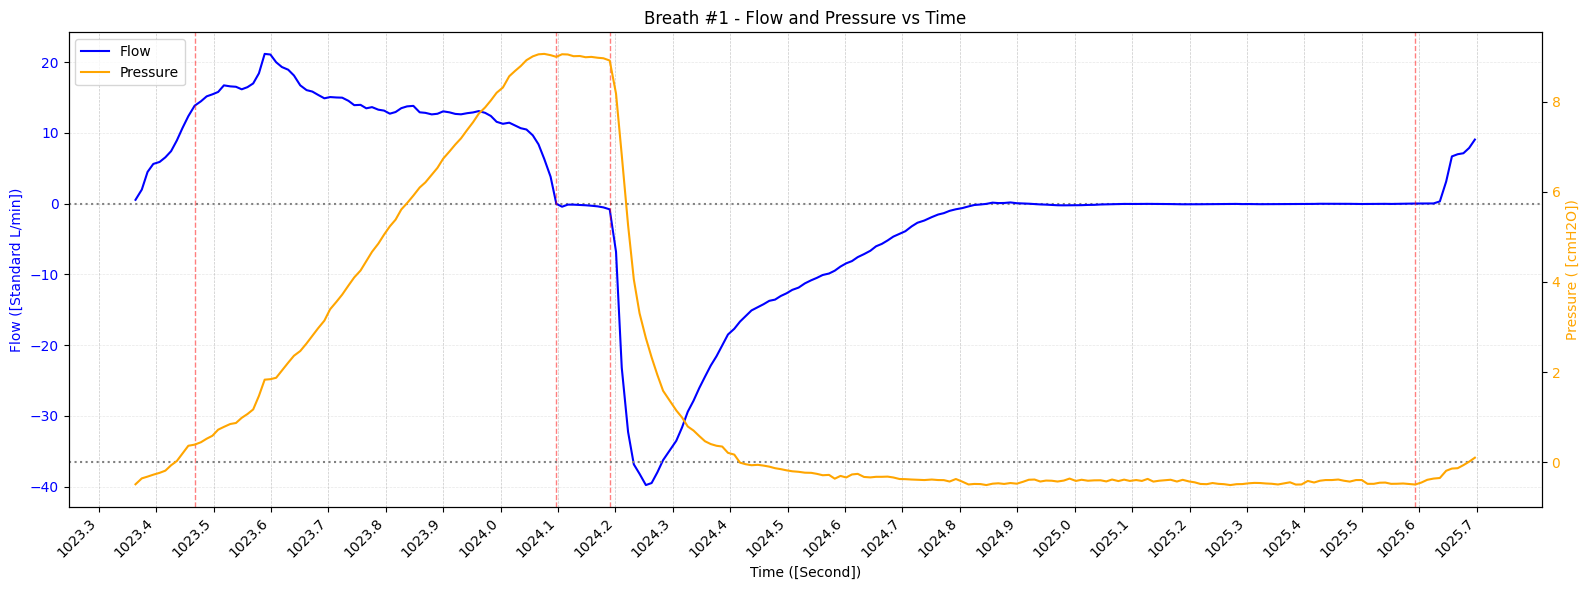


Plotting breath 2/25


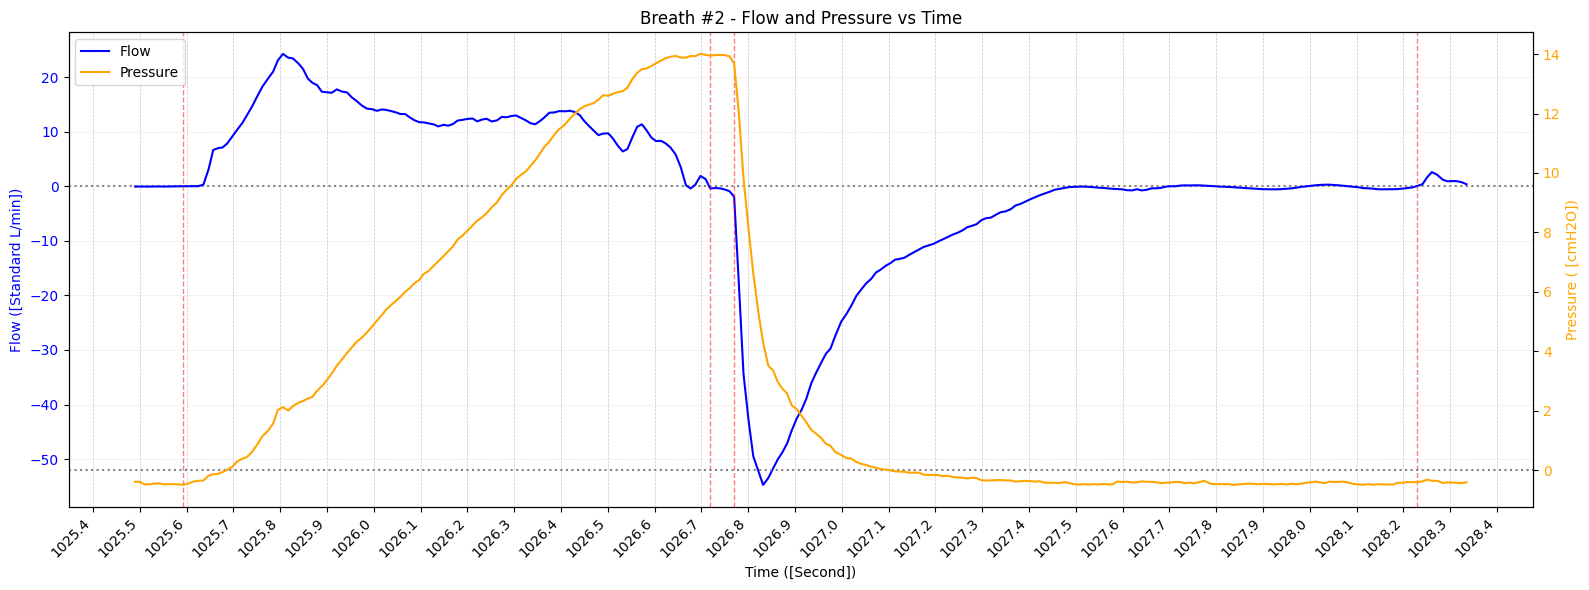


Plotting breath 3/25


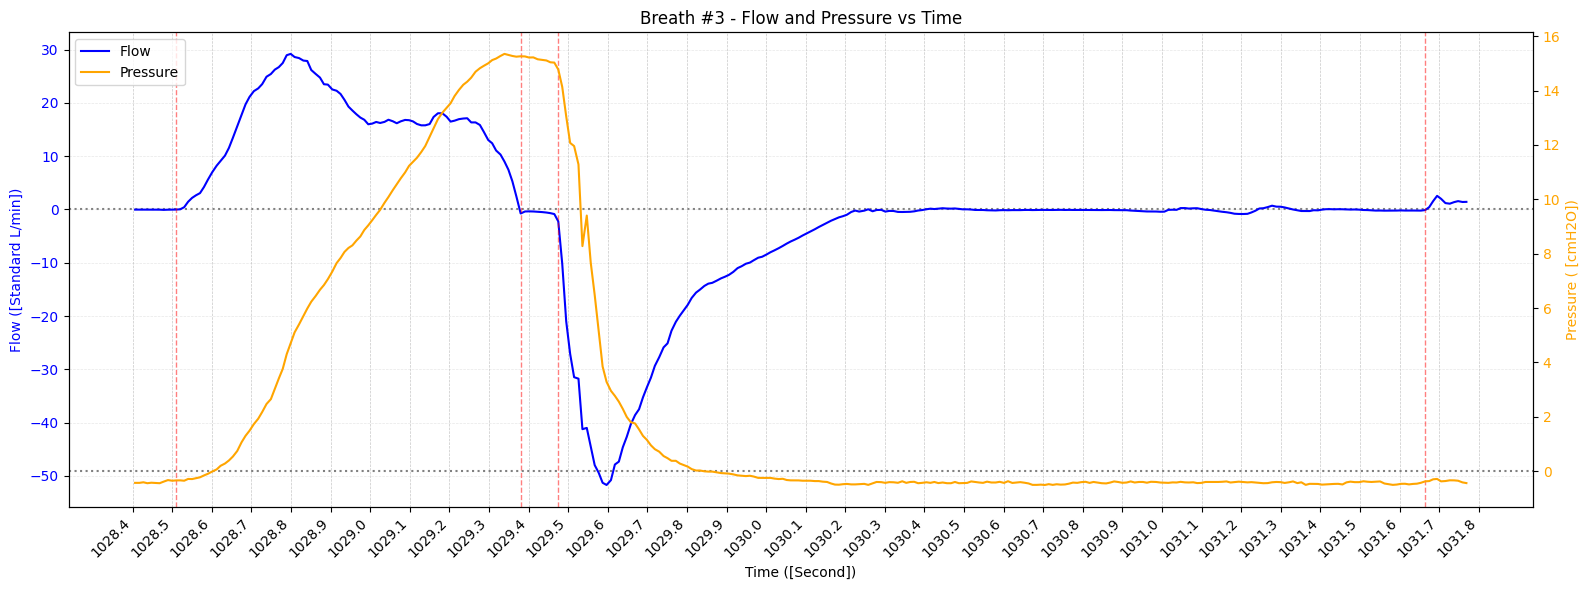


Plotting breath 4/25


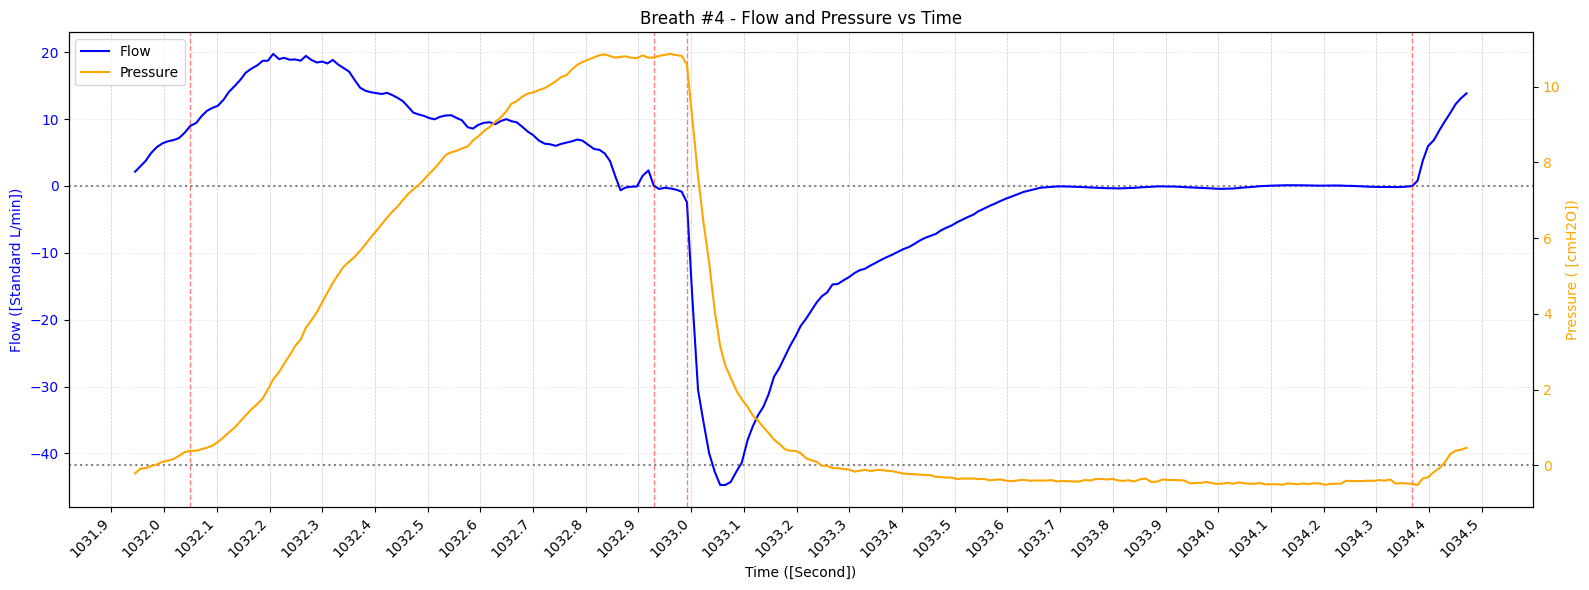


Plotting breath 5/25


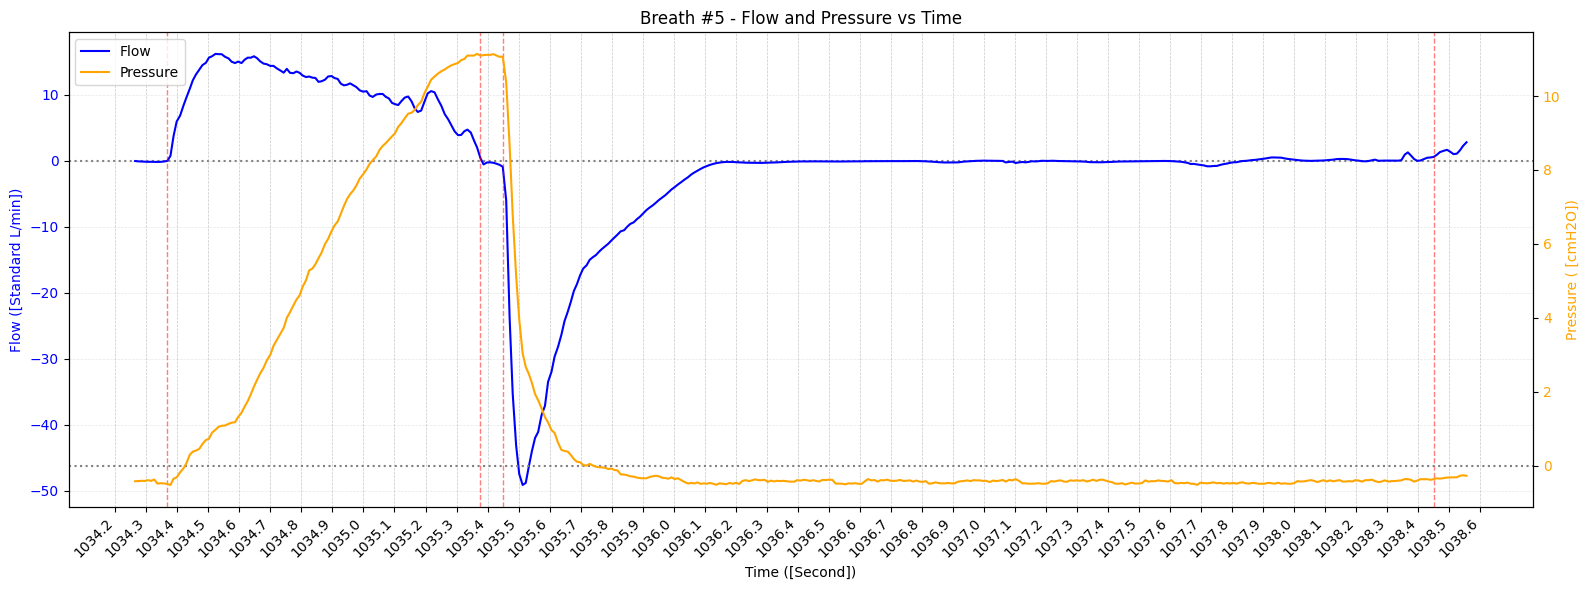


Plotting breath 6/25


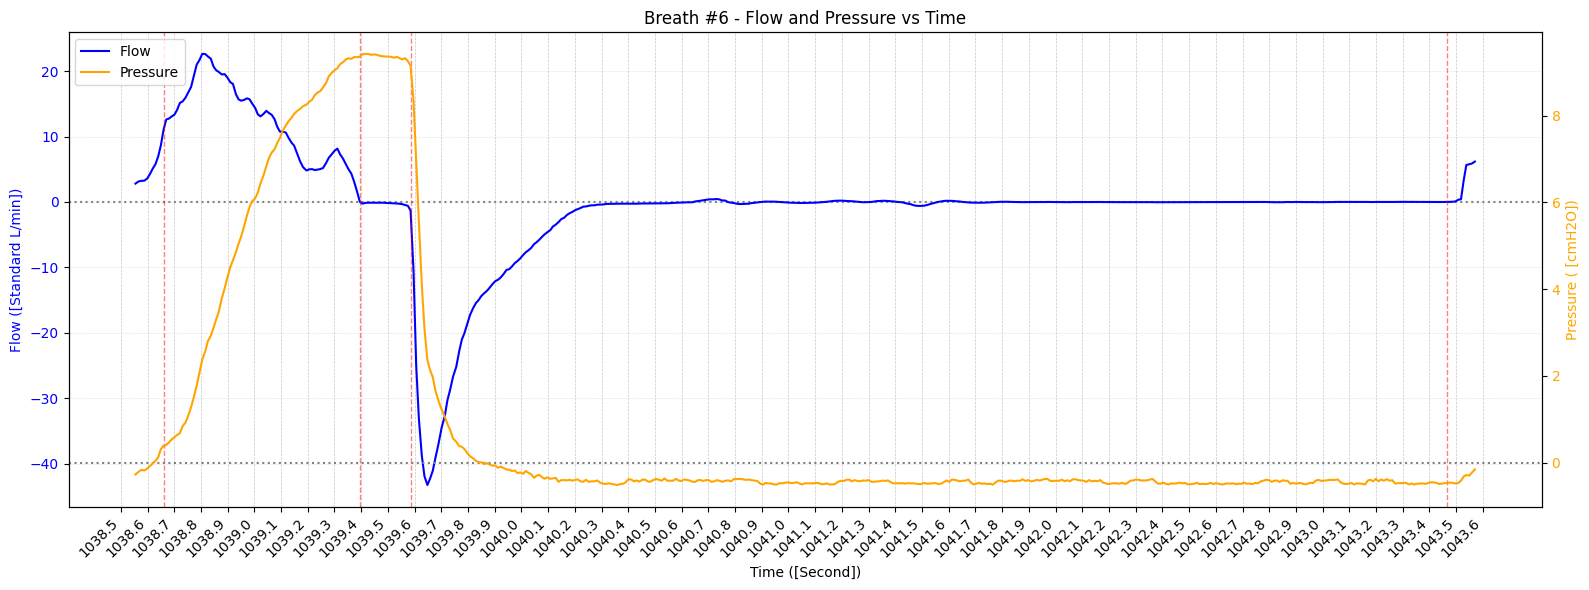


Plotting breath 7/25


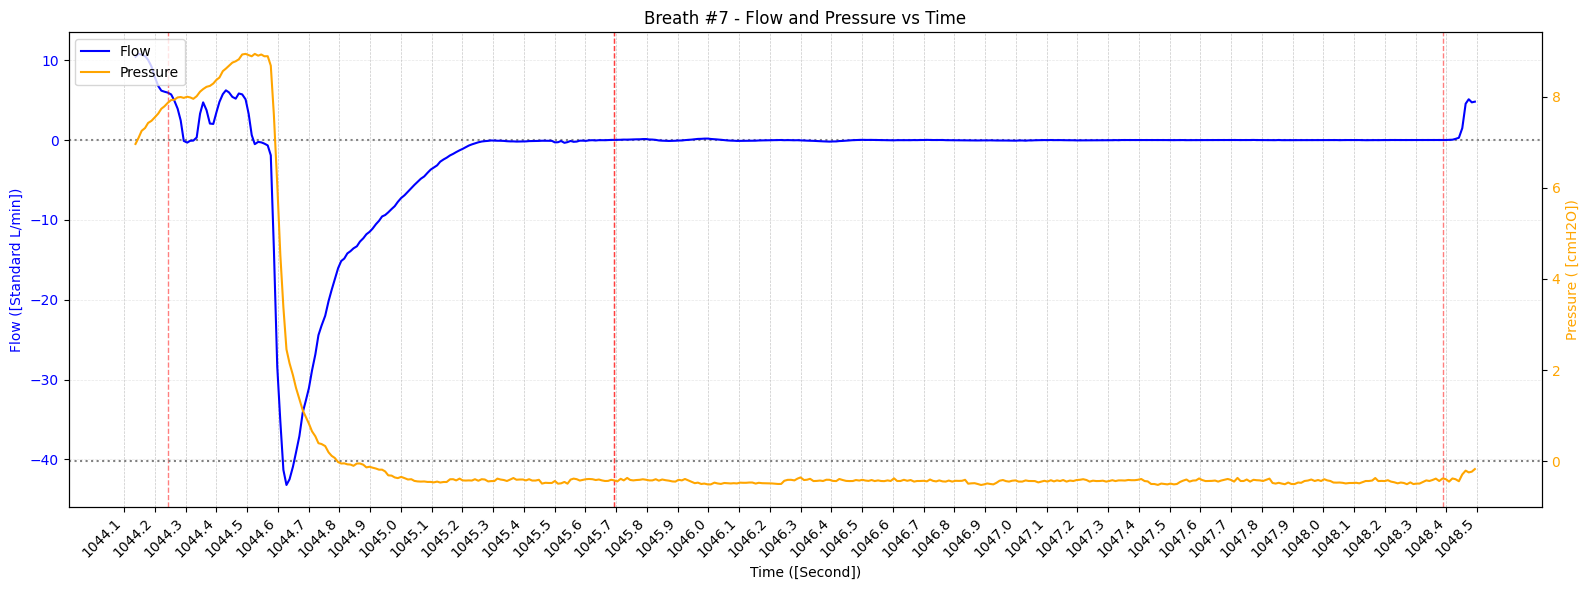


Plotting breath 8/25


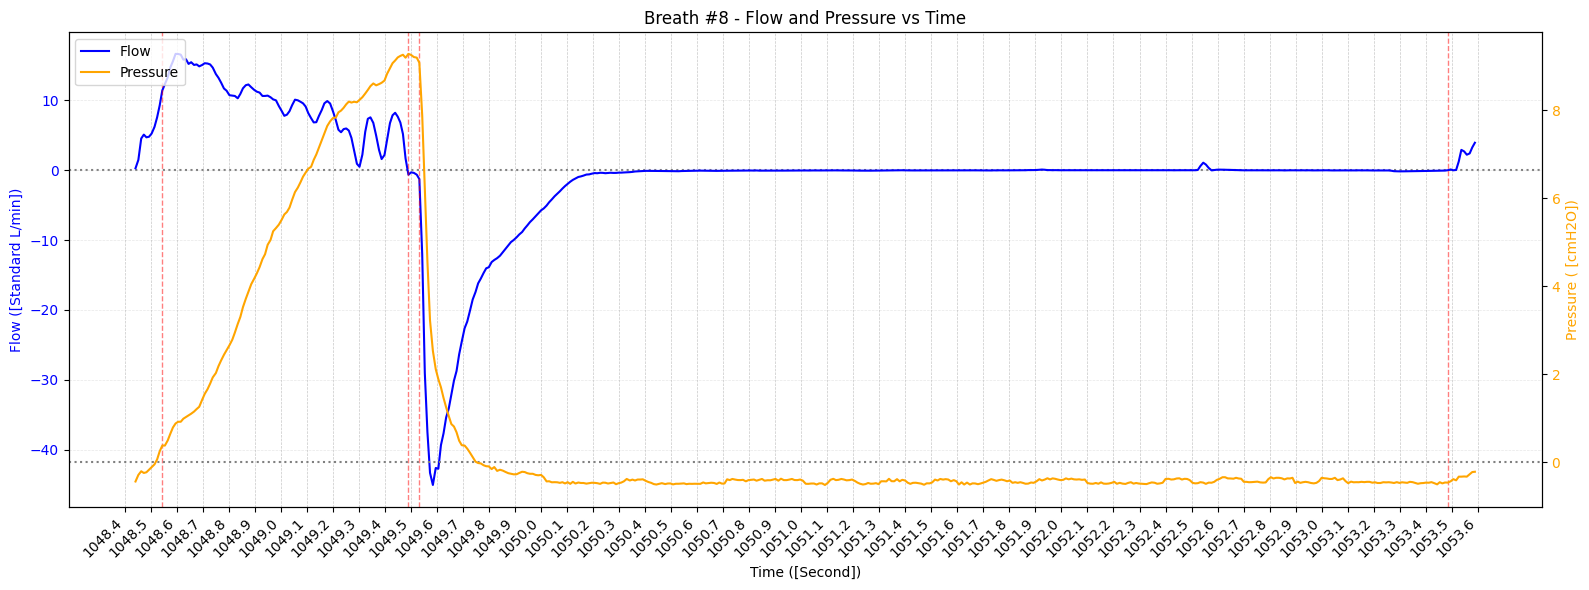


Plotting breath 9/25


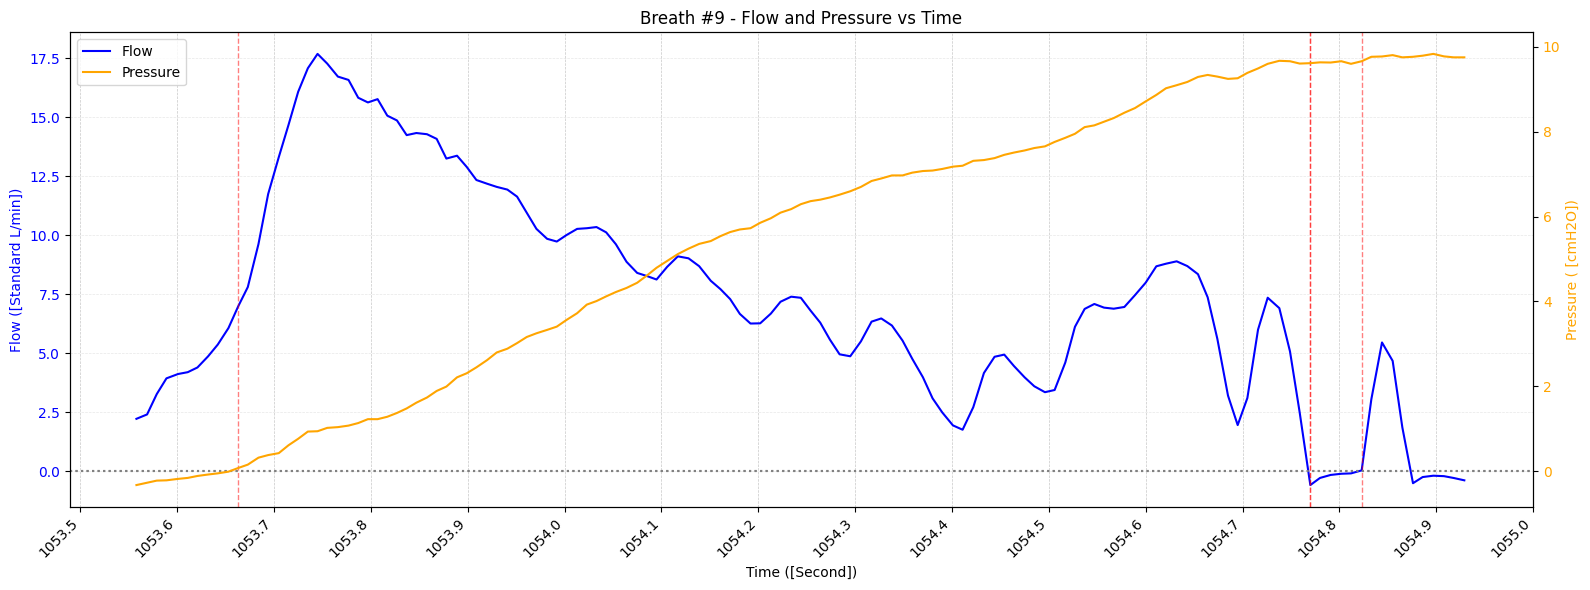


Plotting breath 10/25


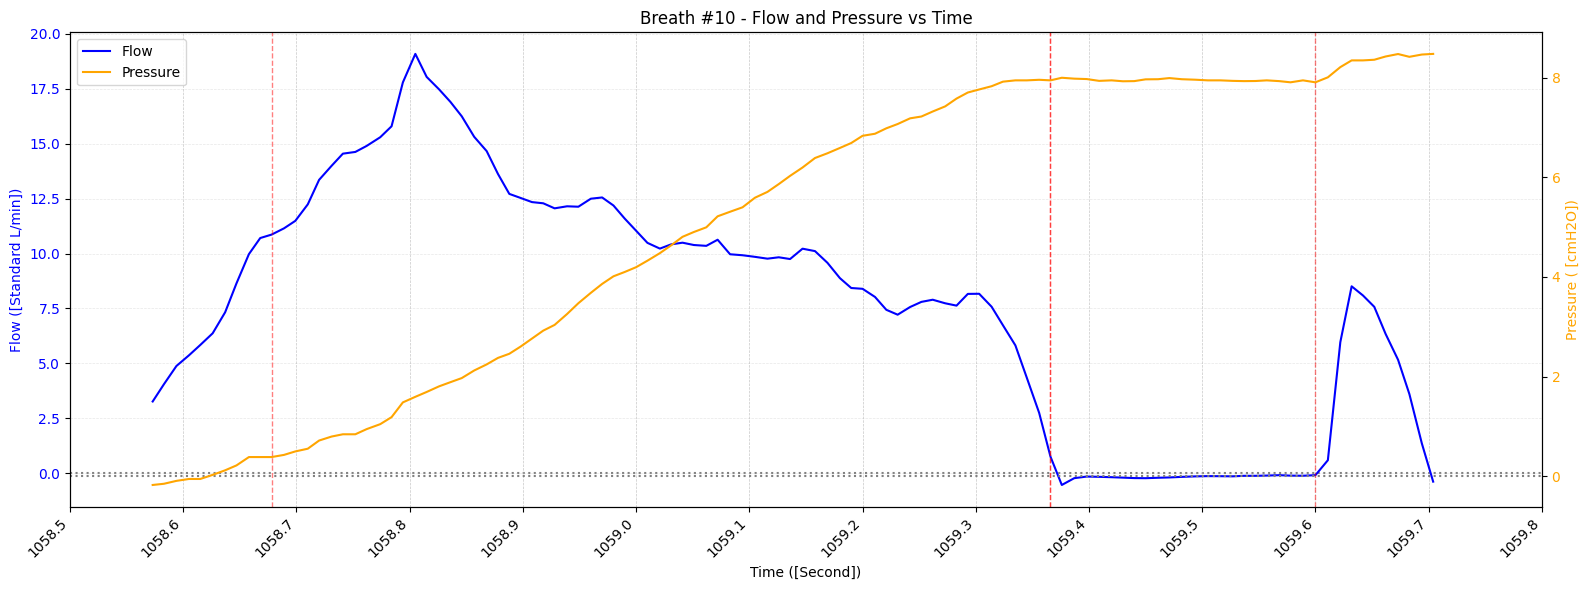


Plotting breath 11/25


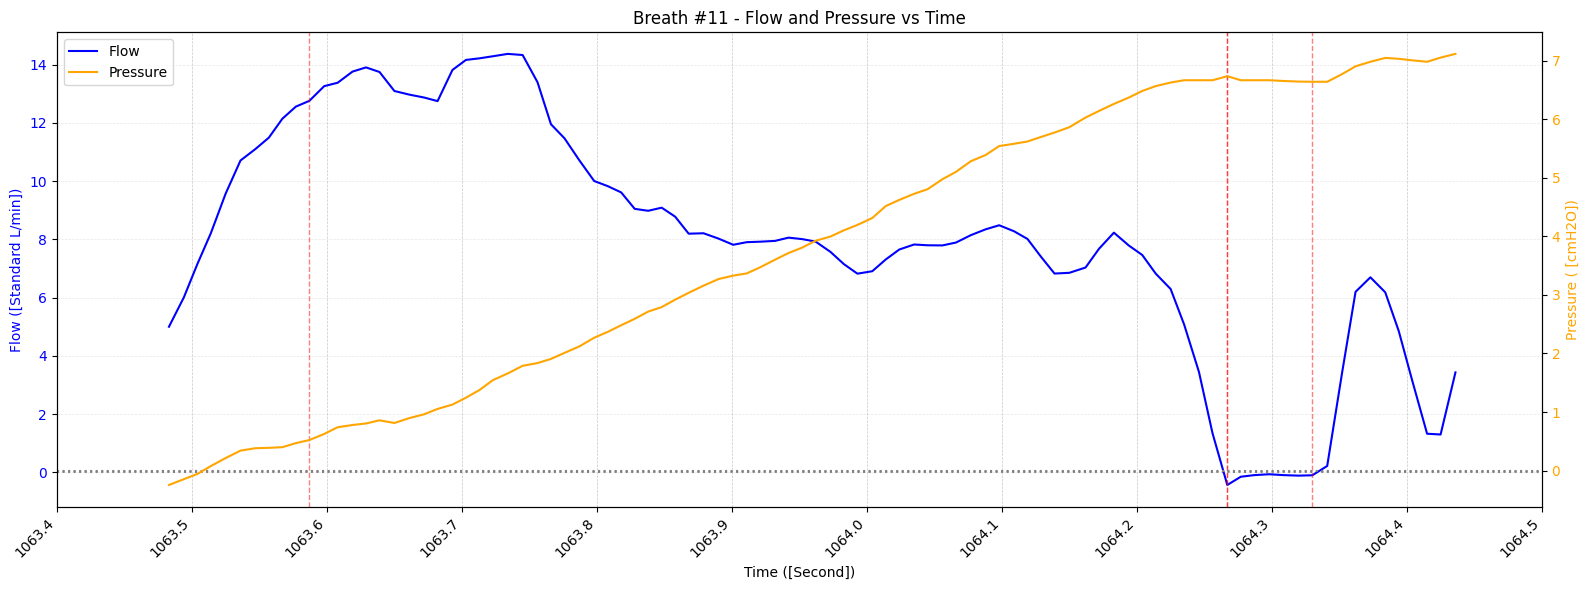


Plotting breath 12/25


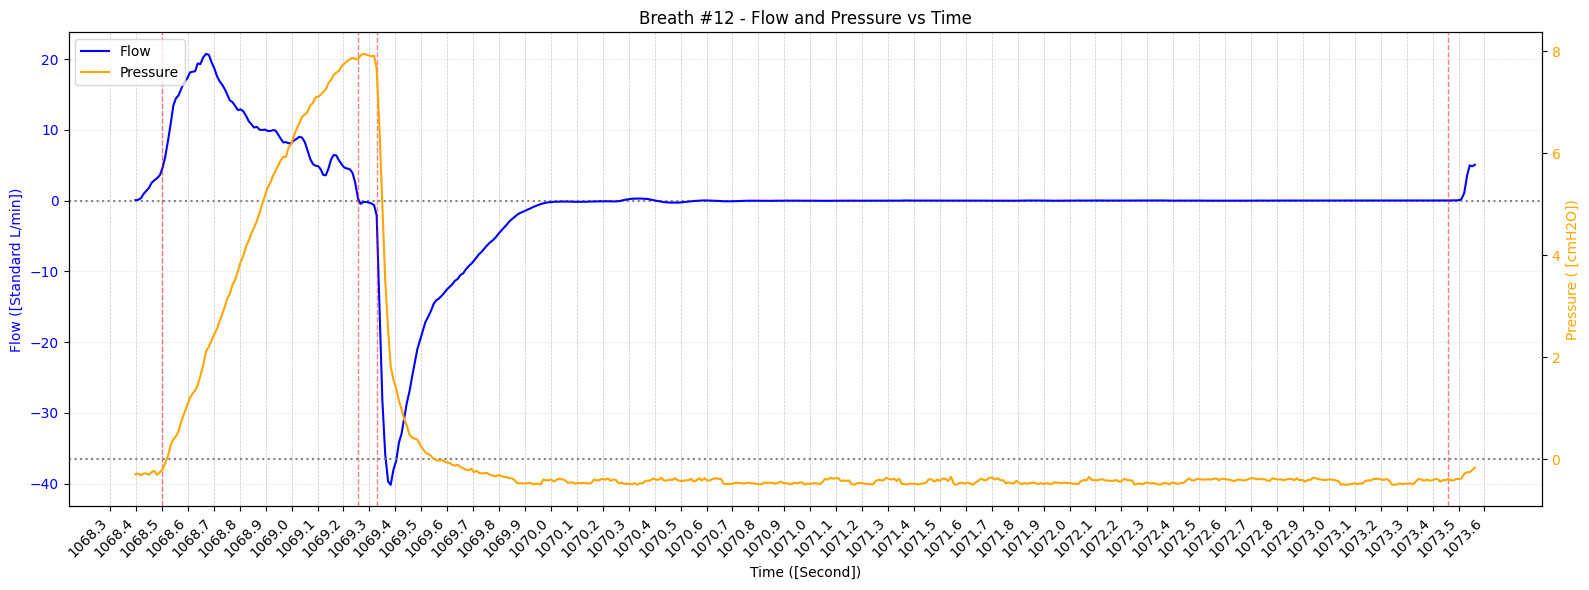


Plotting breath 13/25


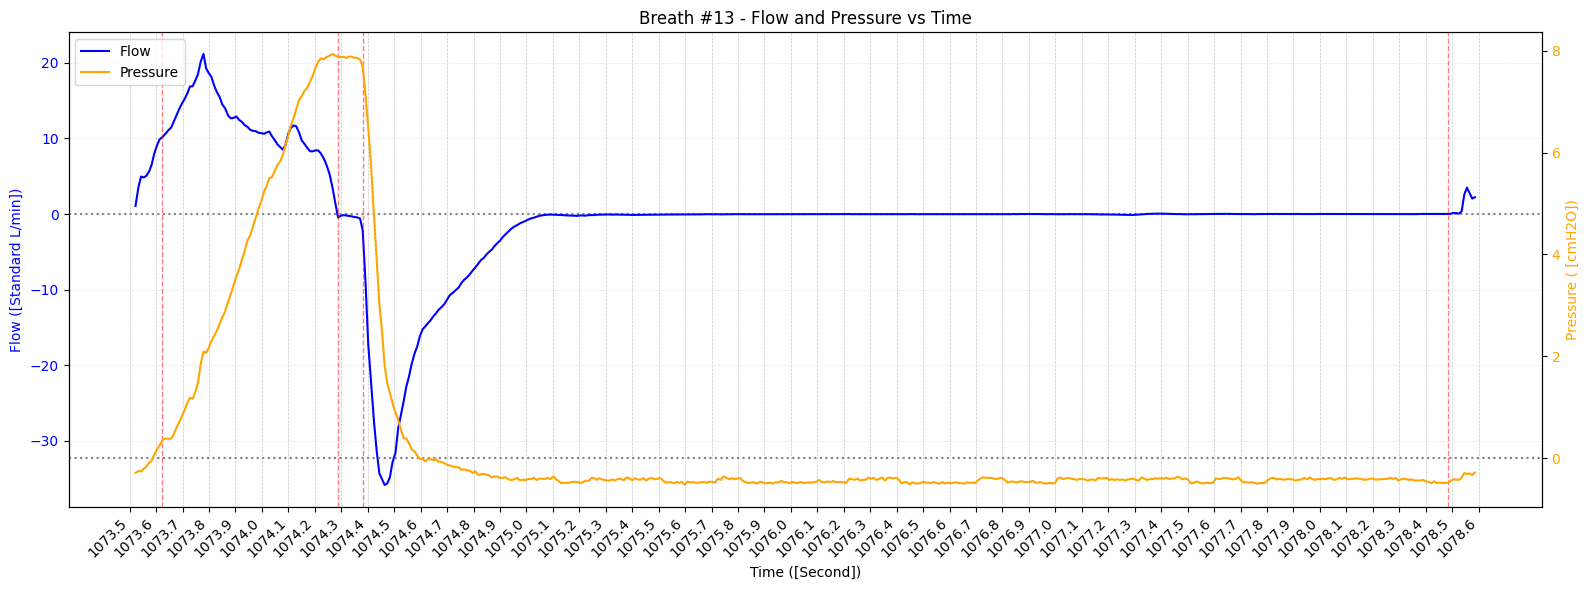


Plotting breath 14/25


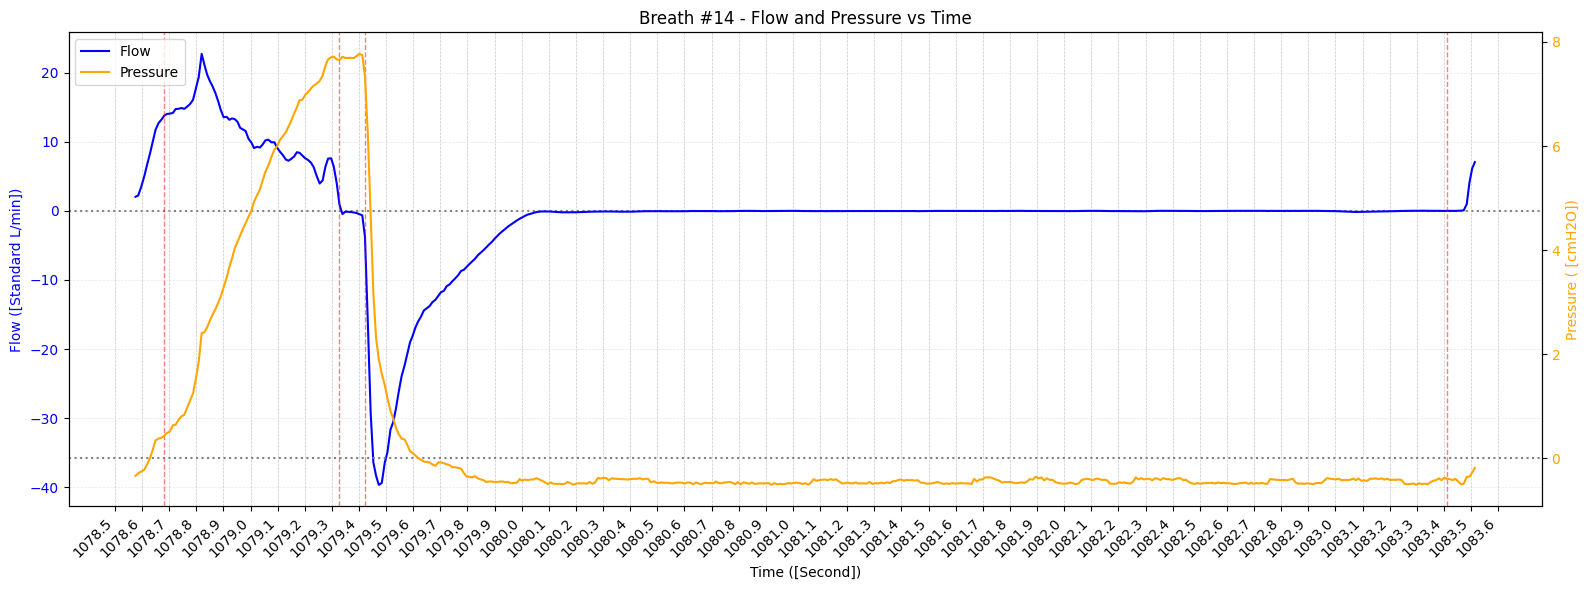


Plotting breath 15/25


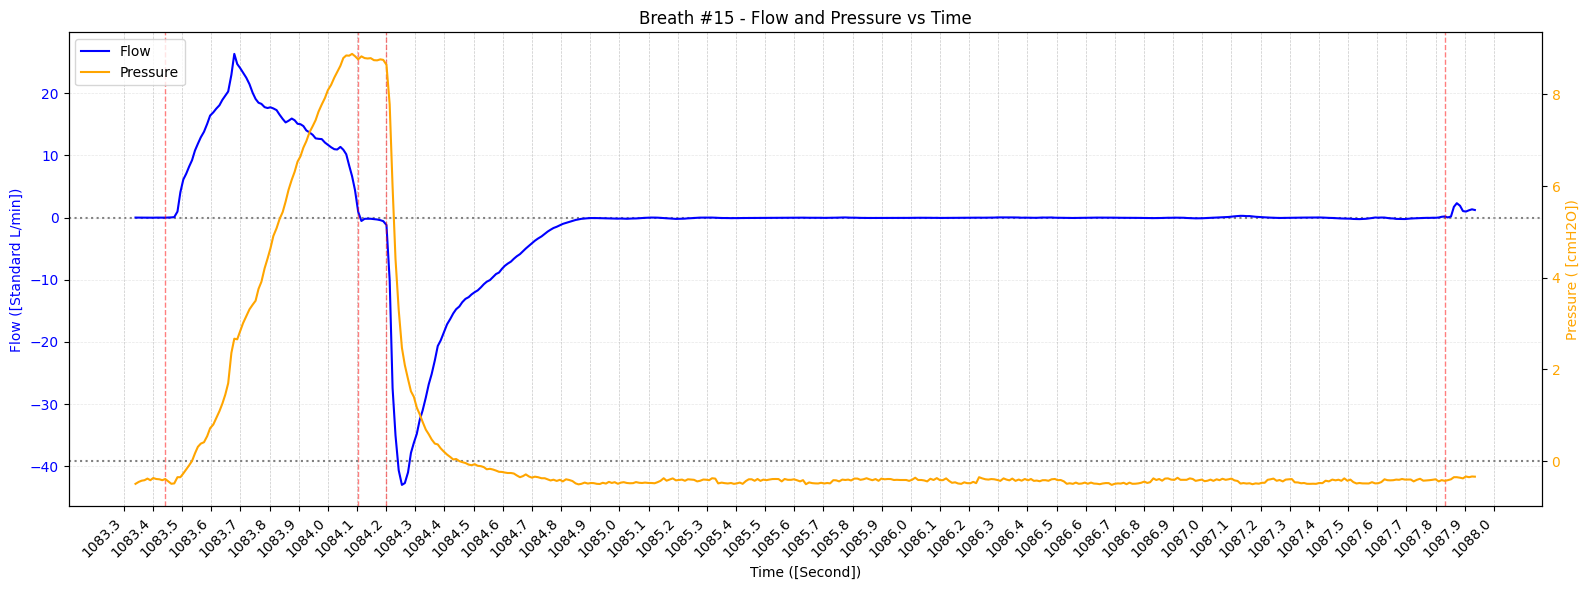


Plotting breath 16/25


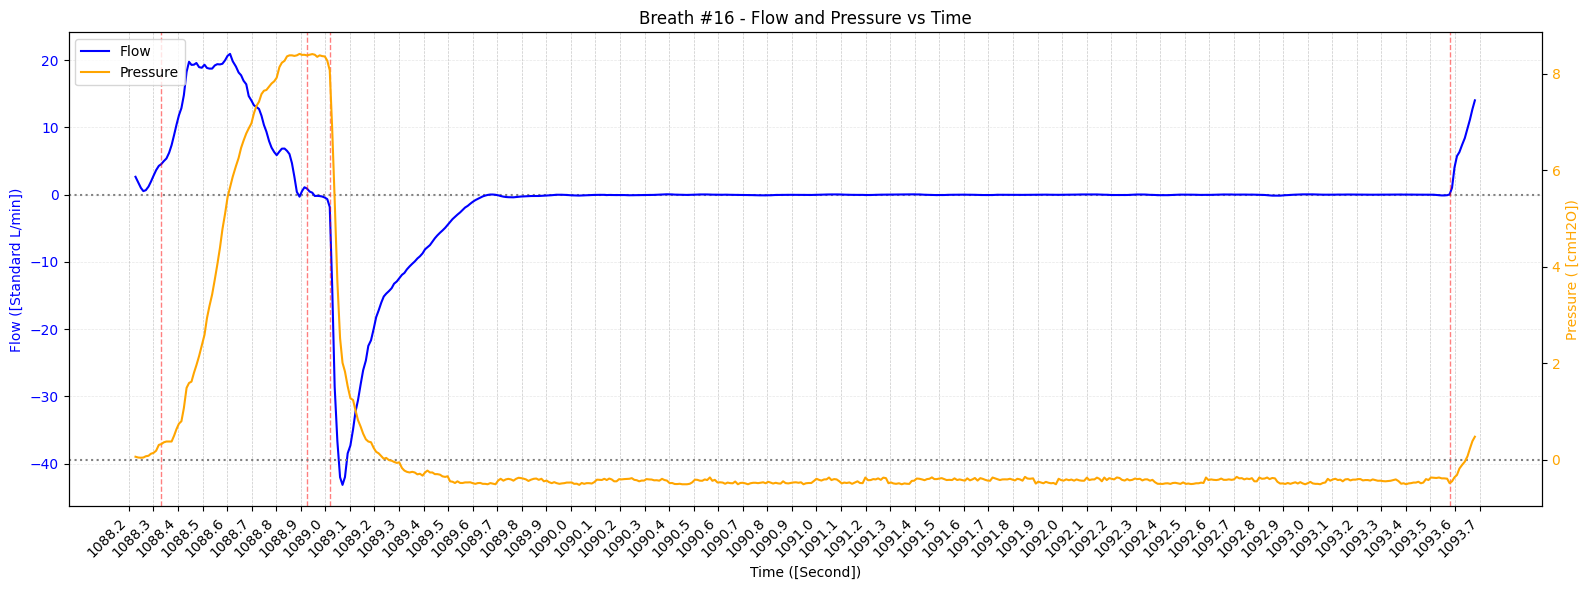


Plotting breath 17/25


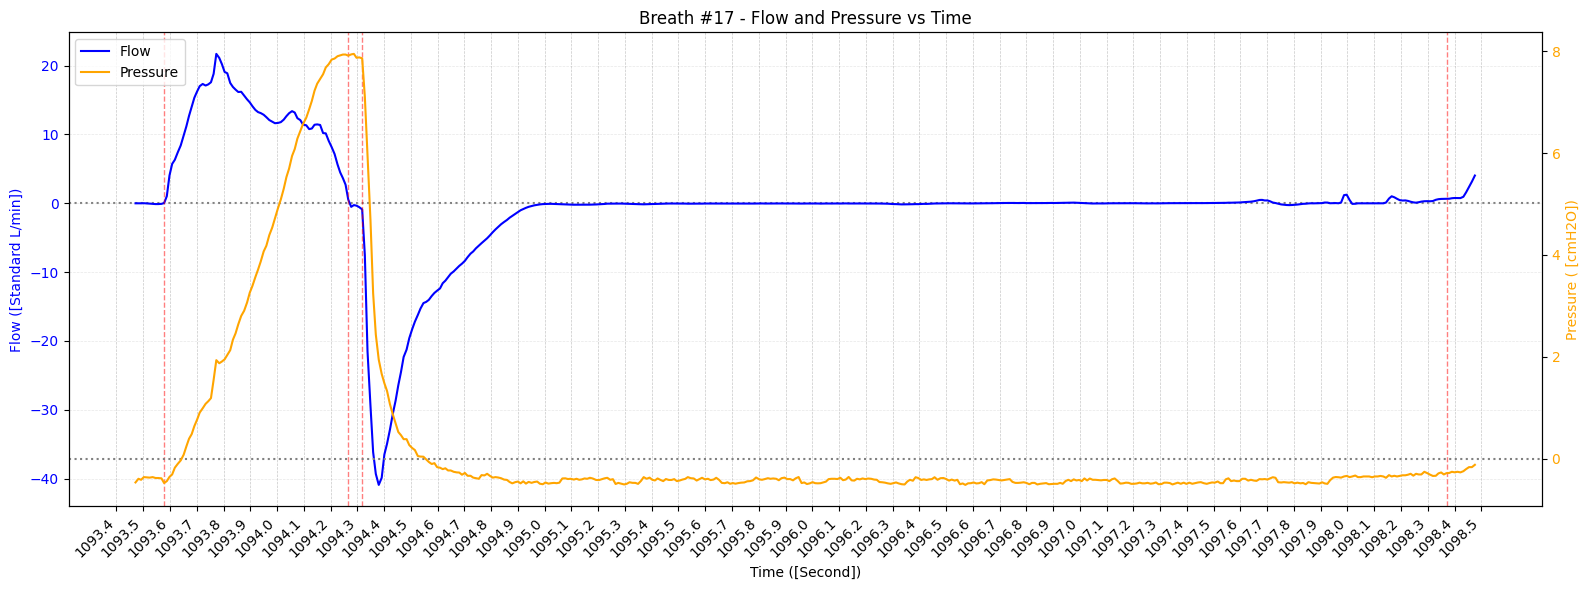


Plotting breath 18/25


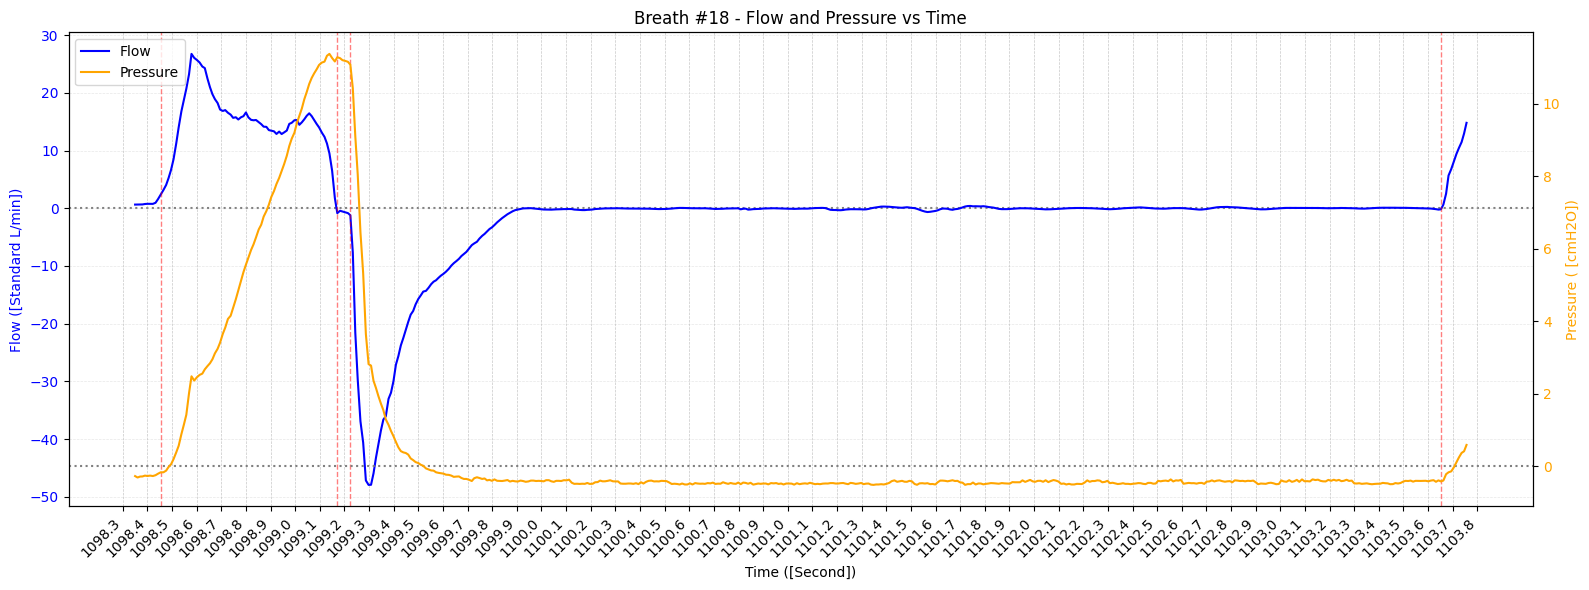


Plotting breath 19/25


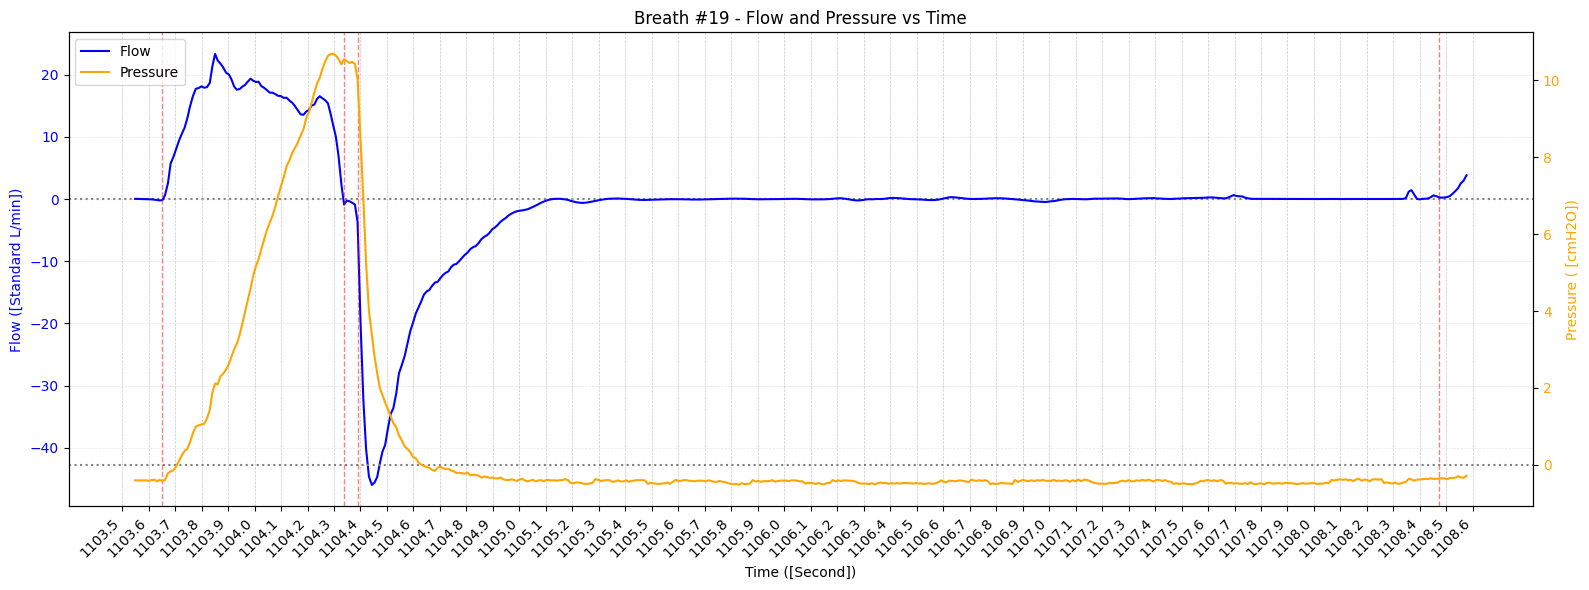


Plotting breath 20/25


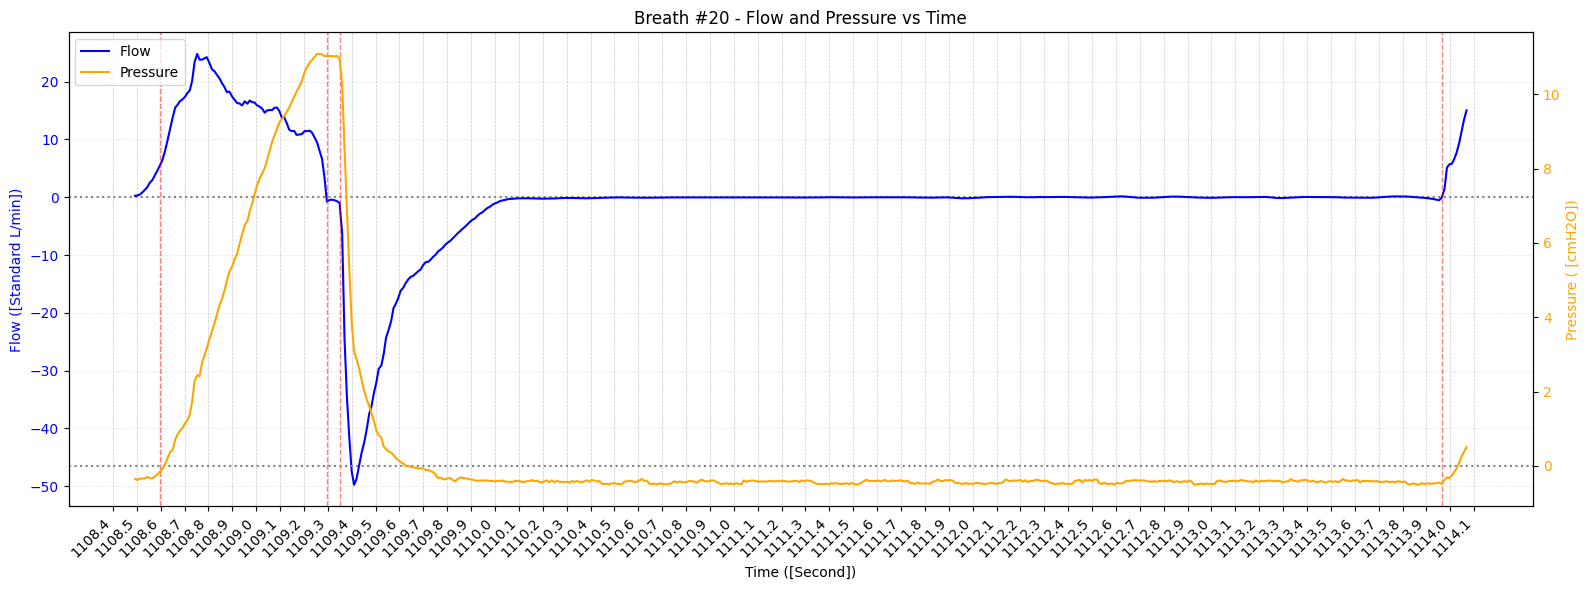


Plotting breath 21/25


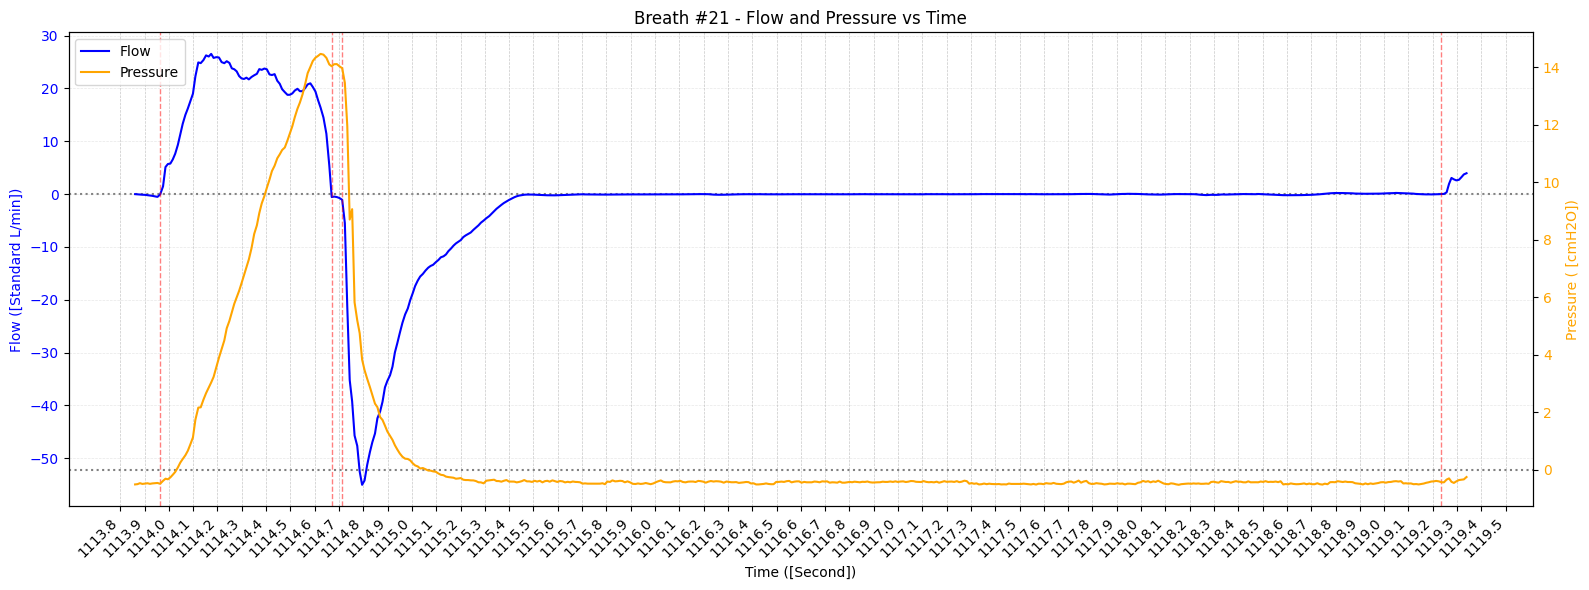


Plotting breath 22/25


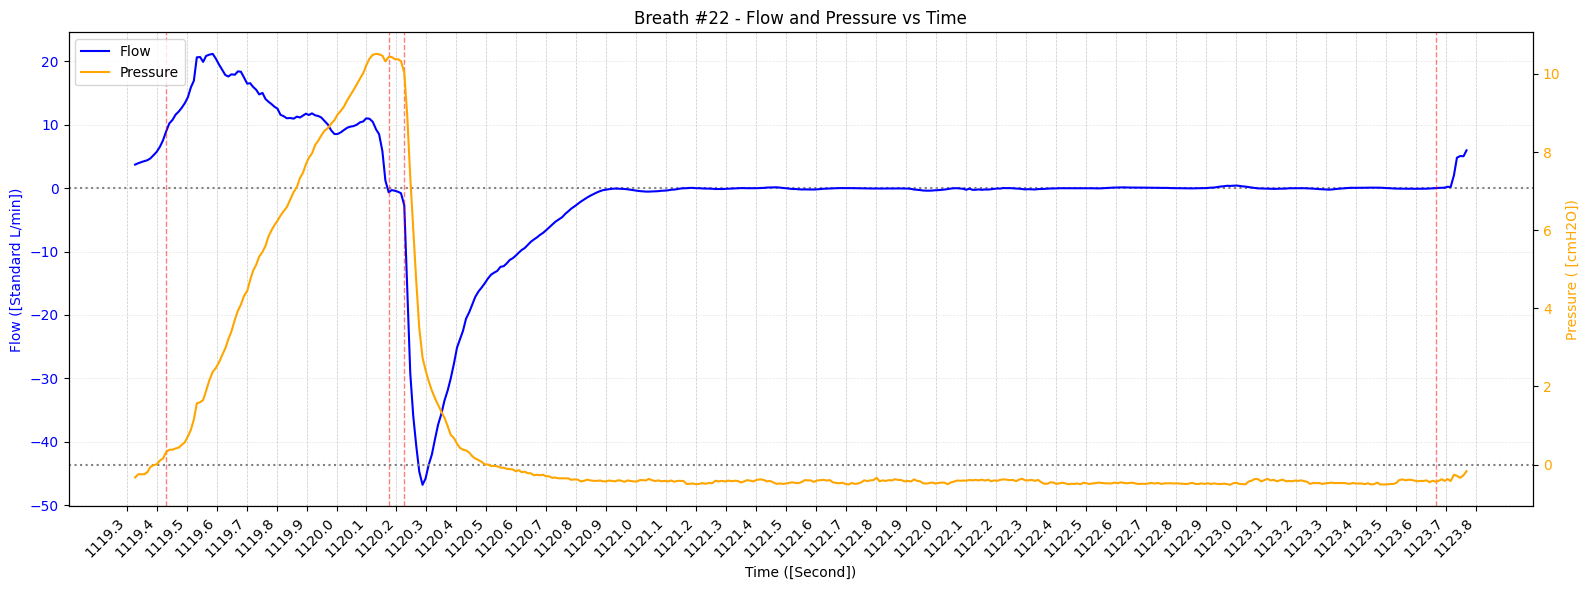


Plotting breath 23/25


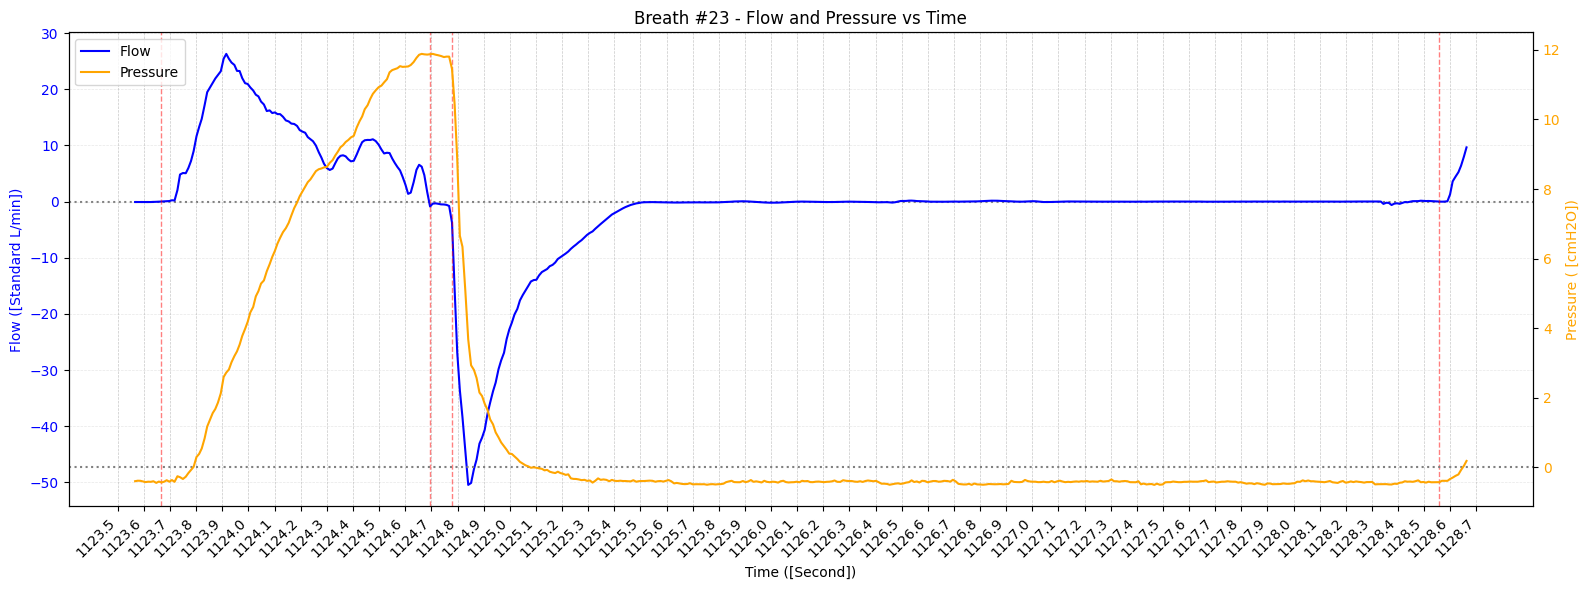


Plotting breath 24/25


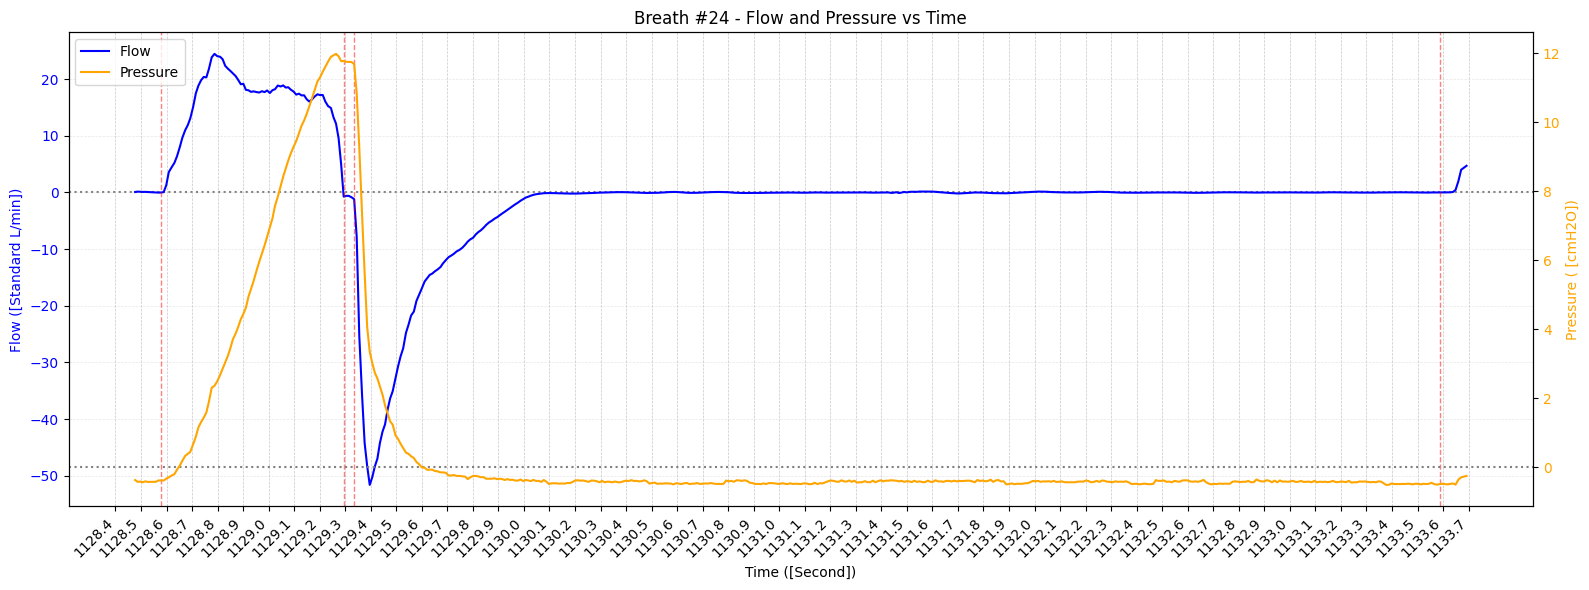


Plotting breath 25/25


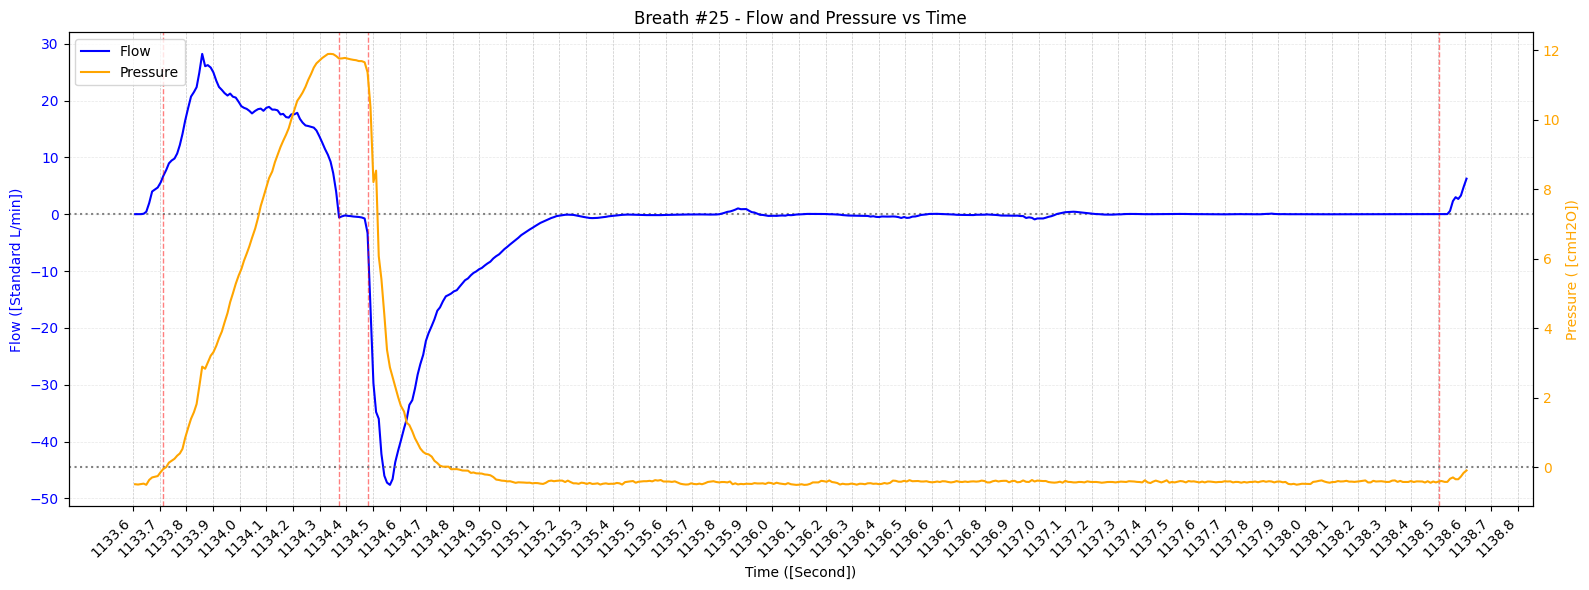

Automated review completed


In [ ]:
# Option 1: Run automated review to see all breaths sequentially
plt.close('all')
system.run_automated_review()

User QA part: choose the breath, update the breath, confirm the breath, and confirm all

Please let all the time_flag blank empty when you change the breath.

Confirm all will disable all the other button.

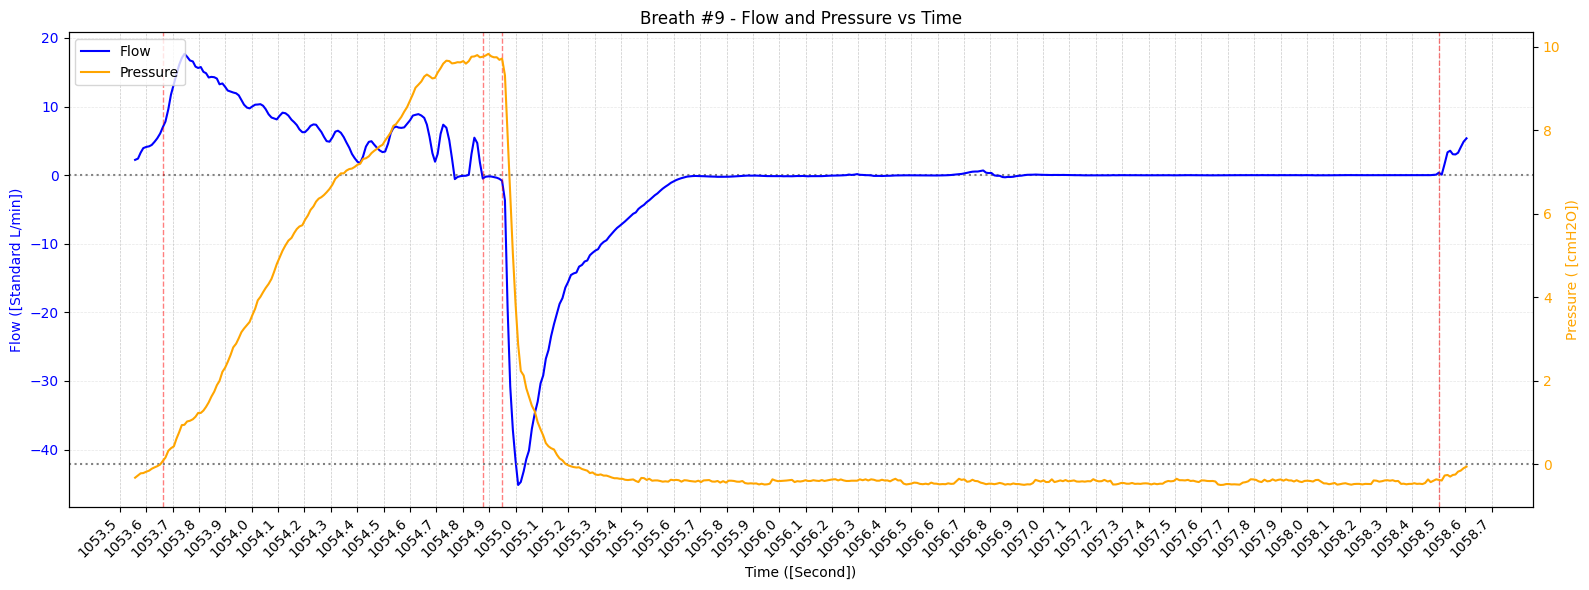

In [ ]:
# Option 2: Start interactive review interface to modify breaths
plt.close('all')
system.start_user_review()

## Final Table Generate

Use the user defined breath table to generate the final csv file
(your browser will ask your permission to download two files)

"doctor_breath_table_XXX.csv" is the end output table for RedCAP update

"dev_doctor_breath_table_XXX.csv" is the feedback file for algorithm improvement

Please upload the raw file and "dev_doctor_breath_table" to this Google Drive:

https://drive.google.com/drive/folders/1JIMf01V56f8WYWs3vxAD24PXrTDcEPuV?usp=sharing

In [ ]:
# After review, you can get the updated data:
doctor_breath_table_PD = system.get_updated_breath_data()

doctor_breath_table_PD = refine_qa_breath_table(real_data_PD, doctor_breath_table_PD)
if upload_raw_file:
    doctor_breath_csv_file = f"doctor_breath_table_{upload_raw_file}"
    result = generate_custom_csv(doctor_breath_table_PD, doctor_breath_csv_file, column_mapping)
    display(result)

    dev_doctor_breath_csv_file = f"dev_doctor_breath_table_{upload_raw_file}"
    dev_result = generate_custom_csv(doctor_breath_table_PD, dev_doctor_breath_csv_file, developer_mapping)
